In [42]:
# %load plotting.py
#
# Copyright 2018 Quantopian, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from __future__ import division

import datetime
from collections import OrderedDict
from functools import wraps

import empyrical as ep
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import scipy as sp
from matplotlib import figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.ticker import FuncFormatter

import seaborn as sns
from pyfolio import capacity
from pyfolio import pos
from pyfolio import timeseries
from pyfolio import txn
from pyfolio import utils
from pyfolio.utils import (APPROX_BDAYS_PER_MONTH,
                    MM_DISPLAY_UNIT)


def customize(func):
    """
    Decorator to set plotting context and axes style during function call.
    """
    @wraps(func)
    def call_w_context(*args, **kwargs):
        set_context = kwargs.pop('set_context', True)
        if set_context:
            with plotting_context(), axes_style():
                return func(*args, **kwargs)
        else:
            return func(*args, **kwargs)
    return call_w_context


def plotting_context(context='notebook', font_scale=1.5, rc=None):
    """
    Create pyfolio default plotting style context.

    Under the hood, calls and returns seaborn.plotting_context() with
    some custom settings. Usually you would use in a with-context.

    Parameters
    ----------
    context : str, optional
        Name of seaborn context.
    font_scale : float, optional
        Scale font by factor font_scale.
    rc : dict, optional
        Config flags.
        By default, {'lines.linewidth': 1.5}
        is being used and will be added to any
        rc passed in, unless explicitly overriden.

    Returns
    -------
    seaborn plotting context

    Example
    -------
    >>> with pyfolio.plotting.plotting_context(font_scale=2):
    >>>    pyfolio.create_full_tear_sheet(..., set_context=False)

    See also
    --------
    For more information, see seaborn.plotting_context().

    """
    if rc is None:
        rc = {}

    rc_default = {'lines.linewidth': 1.5}

    # Add defaults if they do not exist
    for name, val in rc_default.items():
        rc.setdefault(name, val)

    return sns.plotting_context(context=context, font_scale=font_scale, rc=rc)


def axes_style(style='darkgrid', rc=None):
    """
    Create pyfolio default axes style context.

    Under the hood, calls and returns seaborn.axes_style() with
    some custom settings. Usually you would use in a with-context.

    Parameters
    ----------
    style : str, optional
        Name of seaborn style.
    rc : dict, optional
        Config flags.

    Returns
    -------
    seaborn plotting context

    Example
    -------
    >>> with pyfolio.plotting.axes_style(style='whitegrid'):
    >>>    pyfolio.create_full_tear_sheet(..., set_context=False)

    See also
    --------
    For more information, see seaborn.plotting_context().

    """
    if rc is None:
        rc = {}

    rc_default = {}

    # Add defaults if they do not exist
    for name, val in rc_default.items():
        rc.setdefault(name, val)

    return sns.axes_style(style=style, rc=rc)


def plot_monthly_returns_heatmap(returns, ax=None, **kwargs):
    """
    Plots a heatmap of returns by month.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to seaborn plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    monthly_ret_table = ep.aggregate_returns(returns, 'monthly')
    monthly_ret_table = monthly_ret_table.unstack().round(3)

    sns.heatmap(
        monthly_ret_table.fillna(0) *
        100.0,
        annot=True,
        annot_kws={"size": 9},
        alpha=1.0,
        center=0.0,
        cbar=False,
        cmap=matplotlib.cm.RdYlGn,
        ax=ax, **kwargs)
    ax.set_ylabel('Year')
    ax.set_xlabel('Month')
    ax.set_title("Monthly returns (%)")
    return ax


def plot_annual_returns(returns, ax=None, **kwargs):
    """
    Plots a bar graph of returns by year.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    x_axis_formatter = FuncFormatter(utils.percentage)
    ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
    ax.tick_params(axis='x', which='major')

    ann_ret_df = pd.DataFrame(
        ep.aggregate_returns(
            returns,
            'yearly'))

    ax.axvline(
        100 *
        ann_ret_df.values.mean(),
        color='steelblue',
        linestyle='--',
        lw=4,
        alpha=0.7)
    (100 * ann_ret_df.sort_index(ascending=False)
     ).plot(ax=ax, kind='barh', alpha=0.70, **kwargs)
    ax.axvline(0.0, color='black', linestyle='-', lw=3)

    ax.set_ylabel('Year')
    ax.set_xlabel('Returns')
    ax.set_title("Annual returns")
    ax.legend(['Mean'], frameon=True, framealpha=0.5)
    return ax


def plot_monthly_returns_dist(returns, ax=None, **kwargs):
    """
    Plots a distribution of monthly returns.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    x_axis_formatter = FuncFormatter(utils.percentage)
    ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
    ax.tick_params(axis='x', which='major')

    monthly_ret_table = ep.aggregate_returns(returns, 'monthly')

    ax.hist(
        100 * monthly_ret_table,
        color='orangered',
        alpha=0.80,
        bins=20,
        **kwargs)

    ax.axvline(
        100 * monthly_ret_table.mean(),
        color='gold',
        linestyle='--',
        lw=4,
        alpha=1.0)

    ax.axvline(0.0, color='black', linestyle='-', lw=3, alpha=0.75)
    ax.legend(['Mean'], frameon=True, framealpha=0.5)
    ax.set_ylabel('Number of months')
    ax.set_xlabel('Returns')
    ax.set_title("Distribution of monthly returns")
    return ax


def plot_holdings(returns, positions, legend_loc='best', ax=None, **kwargs):
    """
    Plots total amount of stocks with an active position, either short
    or long. Displays daily total, daily average per month, and
    all-time daily average.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    legend_loc : matplotlib.loc, optional
        The location of the legend on the plot.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    positions = positions.copy().drop('cash', axis='columns')
    df_holdings = positions.replace(0, np.nan).count(axis=1)
    df_holdings_by_month = df_holdings.resample('1M').mean()
    df_holdings.plot(color='steelblue', alpha=0.6, lw=0.5, ax=ax, **kwargs)
    df_holdings_by_month.plot(
        color='orangered',
        lw=2,
        ax=ax,
        **kwargs)
    ax.axhline(
        df_holdings.values.mean(),
        color='steelblue',
        ls='--',
        lw=3)

    ax.set_xlim((returns.index[0], returns.index[-1]))

    leg = ax.legend(['Daily holdings',
                     'Average daily holdings, by month',
                     'Average daily holdings, overall'],
                    loc=legend_loc, frameon=True,
                    framealpha=0.5)
    leg.get_frame().set_edgecolor('black')

    ax.set_title('Total holdings')
    ax.set_ylabel('Holdings')
    ax.set_xlabel('')
    return ax


def plot_long_short_holdings(returns, positions,
                             legend_loc='upper left', ax=None, **kwargs):
    """
    Plots total amount of stocks with an active position, breaking out
    short and long into transparent filled regions.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    legend_loc : matplotlib.loc, optional
        The location of the legend on the plot.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.

    """

    if ax is None:
        ax = plt.gca()

    positions = positions.drop('cash', axis='columns')
    positions = positions.replace(0, np.nan)
    df_longs = positions[positions > 0].count(axis=1)
    df_shorts = positions[positions < 0].count(axis=1)
    lf = ax.fill_between(df_longs.index, 0, df_longs.values,
                         color='g', alpha=0.5, lw=2.0)
    sf = ax.fill_between(df_shorts.index, 0, df_shorts.values,
                         color='r', alpha=0.5, lw=2.0)

    bf = patches.Rectangle([0, 0], 1, 1, color='darkgoldenrod')
    leg = ax.legend([lf, sf, bf],
                    ['Long (max: %s, min: %s)' % (df_longs.max(),
                                                  df_longs.min()),
                     'Short (max: %s, min: %s)' % (df_shorts.max(),
                                                   df_shorts.min()),
                     'Overlap'], loc=legend_loc, frameon=True,
                    framealpha=0.5)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlim((returns.index[0], returns.index[-1]))
    ax.set_title('Long and short holdings')
    ax.set_ylabel('Holdings')
    ax.set_xlabel('')
    return ax


def plot_drawdown_periods(returns, top=10, ax=None, **kwargs):
    """
    Plots cumulative returns highlighting top drawdown periods.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    top : int, optional
        Amount of top drawdowns periods to plot (default 10).
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    df_cum_rets = ep.cum_returns(returns, starting_value=1.0)
    df_drawdowns = timeseries.gen_drawdown_table(returns, top=top)

    df_cum_rets.plot(ax=ax, **kwargs)

    lim = ax.get_ylim()
    colors = sns.cubehelix_palette(len(df_drawdowns))[::-1]
    for i, (peak, recovery) in df_drawdowns[
            ['Peak date', 'Recovery date']].iterrows():
        if pd.isnull(recovery):
            recovery = returns.index[-1]
        ax.fill_between((peak, recovery),
                        lim[0],
                        lim[1],
                        alpha=.4,
                        color=colors[i])
    ax.set_ylim(lim)
    ax.set_title('Top %i drawdown periods' % top)
    ax.set_ylabel('Cumulative returns')
    ax.legend(['Portfolio'], loc='upper left',
              frameon=True, framealpha=0.5)
    ax.set_xlabel('')
    return ax


def plot_drawdown_underwater(returns, ax=None, **kwargs):
    """
    Plots how far underwaterr returns are over time, or plots current
    drawdown vs. date.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(utils.percentage)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    df_cum_rets = ep.cum_returns(returns, starting_value=1.0)
    running_max = np.maximum.accumulate(df_cum_rets)
    underwater = -100 * ((running_max - df_cum_rets) / running_max)
    (underwater).plot(ax=ax, kind='area', color='coral', alpha=0.7, **kwargs)
    ax.set_ylabel('Drawdown')
    ax.set_title('Underwater plot')
    ax.set_xlabel('')
    return ax


def plot_perf_stats(returns, factor_returns, ax=None):
    """
    Create box plot of some performance metrics of the strategy.
    The width of the box whiskers is determined by a bootstrap.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    bootstrap_values = timeseries.perf_stats_bootstrap(returns,
                                                       factor_returns,
                                                       return_stats=False)
    bootstrap_values = bootstrap_values.drop('Kurtosis', axis='columns')

    sns.boxplot(data=bootstrap_values, orient='h', ax=ax)

    return ax


STAT_FUNCS_PCT = [
    'Annual return',
    'Cumulative returns',
    'Annual volatility',
    'Max drawdown',
    'Daily value at risk',
    'Daily turnover'
]


def show_perf_stats(returns, factor_returns=None, positions=None,
                    transactions=None, turnover_denom='AGB',
                    live_start_date=None, bootstrap=False,
                    header_rows=None):
    """
    Prints some performance metrics of the strategy.

    - Shows amount of time the strategy has been run in backtest and
      out-of-sample (in live trading).

    - Shows Omega ratio, max drawdown, Calmar ratio, annual return,
      stability, Sharpe ratio, annual volatility, alpha, and beta.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame, optional
        Prices and amounts of executed trades. One row per trade.
        - See full explanation in tears.create_full_tear_sheet
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading, after
        its backtest period.
    bootstrap : boolean, optional
        Whether to perform bootstrap analysis for the performance
        metrics.
         - For more information, see timeseries.perf_stats_bootstrap
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the displayed table.
    """

    if bootstrap:
        perf_func = timeseries.perf_stats_bootstrap
    else:
        perf_func = timeseries.perf_stats

    perf_stats_all = perf_func(
        returns,
        factor_returns=factor_returns,
        positions=positions,
        transactions=transactions,
        turnover_denom=turnover_denom)

    date_rows = OrderedDict()
    if len(returns.index) > 0:
        date_rows['Start date'] = returns.index[0].strftime('%Y-%m-%d')
        date_rows['End date'] = returns.index[-1].strftime('%Y-%m-%d')

    if live_start_date is not None:
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)
        returns_is = returns[returns.index < live_start_date]
        returns_oos = returns[returns.index >= live_start_date]

        positions_is = None
        positions_oos = None
        transactions_is = None
        transactions_oos = None

        if positions is not None:
            positions_is = positions[positions.index < live_start_date]
            positions_oos = positions[positions.index >= live_start_date]
            if transactions is not None:
                transactions_is = transactions[(transactions.index <
                                                live_start_date)]
                transactions_oos = transactions[(transactions.index >
                                                 live_start_date)]

        perf_stats_is = perf_func(
            returns_is,
            factor_returns=factor_returns,
            positions=positions_is,
            transactions=transactions_is,
            turnover_denom=turnover_denom)

        perf_stats_oos = perf_func(
            returns_oos,
            factor_returns=factor_returns,
            positions=positions_oos,
            transactions=transactions_oos,
            turnover_denom=turnover_denom)
        if len(returns.index) > 0:
            date_rows['In-sample months'] = int(len(returns_is) /
                                                APPROX_BDAYS_PER_MONTH)
            date_rows['Out-of-sample months'] = int(len(returns_oos) /
                                                    APPROX_BDAYS_PER_MONTH)

        perf_stats = pd.concat(OrderedDict([
            ('In-sample', perf_stats_is),
            ('Out-of-sample', perf_stats_oos),
            ('All', perf_stats_all),
        ]), axis=1)
    else:
        if len(returns.index) > 0:
            date_rows['Total months'] = int(len(returns) /
                                            APPROX_BDAYS_PER_MONTH)
        perf_stats = pd.DataFrame(perf_stats_all, columns=['Backtest'])

    for column in perf_stats.columns:
        for stat, value in perf_stats[column].iteritems():
            if stat in STAT_FUNCS_PCT:
                perf_stats.loc[stat, column] = str(np.round(value * 100,
                                                            1)) + '%'
    if header_rows is None:
        header_rows = date_rows
    else:
        header_rows = OrderedDict(header_rows)
        header_rows.update(date_rows)

    utils.print_table(
        perf_stats,
        float_format='{0:.2f}'.format,
        header_rows=header_rows,
    )


def plot_returns(returns,
                 live_start_date=None,
                 ax=None):
    """
    Plots raw returns over time.

    Backtest returns are in green, and out-of-sample (live trading)
    returns are in red.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    live_start_date : datetime, optional
        The date when the strategy began live trading, after
        its backtest period. This date should be normalized.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    ax.set_label('')
    ax.set_ylabel('Returns')

    if live_start_date is not None:
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)
        is_returns = returns.loc[returns.index < live_start_date]
        oos_returns = returns.loc[returns.index >= live_start_date]
        is_returns.plot(ax=ax, color='g')
        oos_returns.plot(ax=ax, color='r')

    else:
        returns.plot(ax=ax, color='g')

    return ax


def plot_rolling_returns(returns,
                         factor_returns=None,
                         live_start_date=None,
                         logy=False,
                         cone_std=None,
                         legend_loc='best',
                         volatility_match=False,
                         cone_function=timeseries.forecast_cone_bootstrap,
                         ax=None, **kwargs):
    """
    Plots cumulative rolling returns versus some benchmarks'.

    Backtest returns are in green, and out-of-sample (live trading)
    returns are in red.

    Additionally, a non-parametric cone plot may be added to the
    out-of-sample returns region.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    live_start_date : datetime, optional
        The date when the strategy began live trading, after
        its backtest period. This date should be normalized.
    logy : bool, optional
        Whether to log-scale the y-axis.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - See timeseries.forecast_cone_bounds for more details.
    legend_loc : matplotlib.loc, optional
        The location of the legend on the plot.
    volatility_match : bool, optional
        Whether to normalize the volatility of the returns to those of the
        benchmark returns. This helps compare strategies with different
        volatilities. Requires passing of benchmark_rets.
    cone_function : function, optional
        Function to use when generating forecast probability cone.
        The function signiture must follow the form:
        def cone(in_sample_returns (pd.Series),
                 days_to_project_forward (int),
                 cone_std= (float, or tuple),
                 starting_value= (int, or float))
        See timeseries.forecast_cone_bootstrap for an example.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    ax.set_xlabel('')
    ax.set_ylabel('Cumulative returns')
    ax.set_yscale('log' if logy else 'linear')

    if volatility_match and factor_returns is None:
        raise ValueError('volatility_match requires passing of '
                         'factor_returns.')
    elif volatility_match and factor_returns is not None:
        bmark_vol = factor_returns.loc[returns.index].std()
        returns = (returns / returns.std()) * bmark_vol

    cum_rets = ep.cum_returns(returns, 1.0)

    y_axis_formatter = FuncFormatter(utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    if factor_returns is not None:
        cum_factor_returns = ep.cum_returns(
            factor_returns[cum_rets.index], 1.0)
        cum_factor_returns.plot(lw=2, color='gray',
                                label=factor_returns.name, alpha=0.60,
                                ax=ax, **kwargs)

    if live_start_date is not None:
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)
        is_cum_returns = cum_rets.loc[cum_rets.index < live_start_date]
        oos_cum_returns = cum_rets.loc[cum_rets.index >= live_start_date]
    else:
        is_cum_returns = cum_rets
        oos_cum_returns = pd.Series([])

    is_cum_returns.plot(lw=3, color='forestgreen', alpha=0.6,
                        label='Backtest', ax=ax, **kwargs)

    if len(oos_cum_returns) > 0:
        oos_cum_returns.plot(lw=4, color='red', alpha=0.6,
                             label='Live', ax=ax, **kwargs)

        if cone_std is not None:
            if isinstance(cone_std, (float, int)):
                cone_std = [cone_std]

            is_returns = returns.loc[returns.index < live_start_date]
            cone_bounds = cone_function(
                is_returns,
                len(oos_cum_returns),
                cone_std=cone_std,
                starting_value=is_cum_returns[-1])

            cone_bounds = cone_bounds.set_index(oos_cum_returns.index)
            for std in cone_std:
                ax.fill_between(cone_bounds.index,
                                cone_bounds[float(std)],
                                cone_bounds[float(-std)],
                                color='steelblue', alpha=0.5)

    if legend_loc is not None:
        ax.legend(loc=legend_loc, frameon=True, framealpha=0.5)
    ax.axhline(1.0, linestyle='--', color='black', lw=2)

    return ax


def plot_rolling_beta(returns, factor_returns, legend_loc='best',
                      ax=None, **kwargs):
    """
    Plots the rolling 6-month and 12-month beta versus date.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    legend_loc : matplotlib.loc, optional
        The location of the legend on the plot.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    ax.set_title("Rolling portfolio beta to " + str(factor_returns.name))
    ax.set_ylabel('Beta')
    rb_1 = timeseries.rolling_beta(
        returns, factor_returns, rolling_window=APPROX_BDAYS_PER_MONTH * 6)
    rb_1.plot(color='steelblue', lw=3, alpha=0.6, ax=ax, **kwargs)
    rb_2 = timeseries.rolling_beta(
        returns, factor_returns, rolling_window=APPROX_BDAYS_PER_MONTH * 12)
    rb_2.plot(color='grey', lw=3, alpha=0.4, ax=ax, **kwargs)
    ax.axhline(rb_1.mean(), color='steelblue', linestyle='--', lw=3)
    ax.axhline(0.0, color='black', linestyle='-', lw=2)

    ax.set_xlabel('')
    ax.legend(['6-mo',
               '12-mo'],
              loc=legend_loc, frameon=True, framealpha=0.5)
    ax.set_ylim((-1.0, 1.0))
    return ax


def plot_rolling_volatility(returns, factor_returns=None,
                            rolling_window=APPROX_BDAYS_PER_MONTH * 6,
                            legend_loc='best', ax=None, **kwargs):
    """
    Plots the rolling volatility versus date.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    rolling_window : int, optional
        The days window over which to compute the volatility.
    legend_loc : matplotlib.loc, optional
        The location of the legend on the plot.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    rolling_vol_ts = timeseries.rolling_volatility(
        returns, rolling_window)
    rolling_vol_ts.plot(alpha=.7, lw=3, color='orangered', ax=ax,
                        **kwargs)
    if factor_returns is not None:
        rolling_vol_ts_factor = timeseries.rolling_volatility(
            factor_returns, rolling_window)
        rolling_vol_ts_factor.plot(alpha=.7, lw=3, color='grey', ax=ax,
                                   **kwargs)

    ax.set_title('Rolling volatility (6-month)')
    ax.axhline(
        rolling_vol_ts.mean(),
        color='steelblue',
        linestyle='--',
        lw=3)

    ax.axhline(0.0, color='black', linestyle='-', lw=2)

    ax.set_ylabel('Volatility')
    ax.set_xlabel('')
    if factor_returns is None:
        ax.legend(['Volatility', 'Average volatility'],
                  loc=legend_loc, frameon=True, framealpha=0.5)
    else:
        ax.legend(['Volatility', 'Benchmark volatility', 'Average volatility'],
                  loc=legend_loc, frameon=True, framealpha=0.5)
    return ax


def plot_rolling_sharpe(returns, factor_returns=None,
                        rolling_window=APPROX_BDAYS_PER_MONTH * 6,
                        legend_loc='best', ax=None, **kwargs):
    """
    Plots the rolling Sharpe ratio versus date.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor for
        which the benchmark rolling Sharpe is computed. Usually
        a benchmark such as market returns.
         - This is in the same style as returns.
    rolling_window : int, optional
        The days window over which to compute the sharpe ratio.
    legend_loc : matplotlib.loc, optional
        The location of the legend on the plot.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    rolling_sharpe_ts = timeseries.rolling_sharpe(
        returns, rolling_window)
    rolling_sharpe_ts.plot(alpha=.7, lw=3, color='orangered', ax=ax,
                           **kwargs)

    if factor_returns is not None:
        rolling_sharpe_ts_factor = timeseries.rolling_sharpe(
            factor_returns, rolling_window)
        rolling_sharpe_ts_factor.plot(alpha=.7, lw=3, color='grey', ax=ax,
                                      **kwargs)

    ax.set_title('Rolling Sharpe ratio (6-month)')
    ax.axhline(
        rolling_sharpe_ts.mean(),
        color='steelblue',
        linestyle='--',
        lw=3)
    ax.axhline(0.0, color='black', linestyle='-', lw=3)

    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('')
    if factor_returns is None:
        ax.legend(['Sharpe', 'Average'],
                  loc=legend_loc, frameon=True, framealpha=0.5)
    else:
        ax.legend(['Sharpe', 'Benchmark Sharpe', 'Average'],
                  loc=legend_loc, frameon=True, framealpha=0.5)

    return ax


def plot_gross_leverage(returns, positions, ax=None, **kwargs):
    """
    Plots gross leverage versus date.

    Gross leverage is the sum of long and short exposure per share
    divided by net asset value.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()
    gl = timeseries.gross_lev(positions)
    gl.plot(lw=0.5, color='limegreen', legend=False, ax=ax, **kwargs)

    ax.axhline(gl.mean(), color='g', linestyle='--', lw=3)

    ax.set_title('Gross leverage')
    ax.set_ylabel('Gross leverage')
    ax.set_xlabel('')
    return ax


def plot_exposures(returns, positions, ax=None, **kwargs):
    """
    Plots a cake chart of the long and short exposure.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    positions_alloc : pd.DataFrame
        Portfolio allocation of positions. See
        pos.get_percent_alloc.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    pos_no_cash = positions.drop('cash', axis=1)
    l_exp = pos_no_cash[pos_no_cash > 0].sum(axis=1) / positions.sum(axis=1)
    s_exp = pos_no_cash[pos_no_cash < 0].sum(axis=1) / positions.sum(axis=1)
    net_exp = pos_no_cash.sum(axis=1) / positions.sum(axis=1)

    ax.fill_between(l_exp.index,
                    0,
                    l_exp.values,
                    label='Long', color='green', alpha=0.5)
    ax.fill_between(s_exp.index,
                    0,
                    s_exp.values,
                    label='Short', color='red', alpha=0.5)
    ax.plot(net_exp.index, net_exp.values,
            label='Net', color='black', linestyle='dotted')

    ax.set_xlim((returns.index[0], returns.index[-1]))
    ax.set_title("Exposure")
    ax.set_ylabel('Exposure')
    ax.legend(loc='lower left', frameon=True, framealpha=0.5)
    ax.set_xlabel('')
    return ax


def show_and_plot_top_positions(returns, positions_alloc,
                                show_and_plot=2, hide_positions=False,
                                legend_loc='real_best', ax=None,
                                **kwargs):
    """
    Prints and/or plots the exposures of the top 10 held positions of
    all time.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    positions_alloc : pd.DataFrame
        Portfolio allocation of positions. See pos.get_percent_alloc.
    show_and_plot : int, optional
        By default, this is 2, and both prints and plots.
        If this is 0, it will only plot; if 1, it will only print.
    hide_positions : bool, optional
        If True, will not output any symbol names.
    legend_loc : matplotlib.loc, optional
        The location of the legend on the plot.
        By default, the legend will display below the plot.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes, conditional
        The axes that were plotted on.

    """
    positions_alloc = positions_alloc.copy()
    positions_alloc.columns = positions_alloc.columns.map(utils.format_asset)

    df_top_long, df_top_short, df_top_abs = pos.get_top_long_short_abs(
        positions_alloc)

    if show_and_plot == 1 or show_and_plot == 2:
        utils.print_table(pd.DataFrame(df_top_long * 100, columns=['max']),
                          float_format='{0:.2f}%'.format,
                          name='Top 10 long positions of all time')

        utils.print_table(pd.DataFrame(df_top_short * 100, columns=['max']),
                          float_format='{0:.2f}%'.format,
                          name='Top 10 short positions of all time')

        utils.print_table(pd.DataFrame(df_top_abs * 100, columns=['max']),
                          float_format='{0:.2f}%'.format,
                          name='Top 10 positions of all time')

    if show_and_plot == 0 or show_and_plot == 2:

        if ax is None:
            ax = plt.gca()

        positions_alloc[df_top_abs.index].plot(
            title='Portfolio allocation over time, only top 10 holdings',
            alpha=0.5, ax=ax, **kwargs)

        # Place legend below plot, shrink plot by 20%
        if legend_loc == 'real_best':
            box = ax.get_position()
            ax.set_position([box.x0, box.y0 + box.height * 0.1,
                             box.width, box.height * 0.9])

            # Put a legend below current axis
            ax.legend(loc='upper center', frameon=True, framealpha=0.5,
                      bbox_to_anchor=(0.5, -0.14), ncol=5)
        else:
            ax.legend(loc=legend_loc)

        ax.set_xlim((returns.index[0], returns.index[-1]))
        ax.set_ylabel('Exposure by holding')

        if hide_positions:
            ax.legend_.remove()

        return ax


def plot_max_median_position_concentration(positions, ax=None, **kwargs):
    """
    Plots the max and median of long and short position concentrations
    over the time.

    Parameters
    ----------
    positions : pd.DataFrame
        The positions that the strategy takes over time.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gcf()

    alloc_summary = pos.get_max_median_position_concentration(positions)
    colors = ['mediumblue', 'steelblue', 'tomato', 'firebrick']
    alloc_summary.plot(linewidth=1, color=colors, alpha=0.6, ax=ax)

    ax.legend(loc='center left', frameon=True, framealpha=0.5)
    ax.set_ylabel('Exposure')
    ax.set_title('Long/short max and median position concentration')

    return ax


def plot_sector_allocations(returns, sector_alloc, ax=None, **kwargs):
    """
    Plots the sector exposures of the portfolio over time.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    sector_alloc : pd.DataFrame
        Portfolio allocation of positions. See pos.get_sector_alloc.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gcf()

    sector_alloc.plot(title='Sector allocation over time',
                      alpha=0.5, ax=ax, **kwargs)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', frameon=True, framealpha=0.5,
              bbox_to_anchor=(0.5, -0.14), ncol=5)

    ax.set_xlim((sector_alloc.index[0], sector_alloc.index[-1]))
    ax.set_ylabel('Exposure by sector')
    ax.set_xlabel('')

    return ax


def plot_return_quantiles(returns, live_start_date=None, ax=None, **kwargs):
    """
    Creates a box plot of daily, weekly, and monthly return
    distributions.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading, after
        its backtest period.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to seaborn plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    is_returns = returns if live_start_date is None \
        else returns.loc[returns.index < live_start_date]
    is_weekly = ep.aggregate_returns(is_returns, 'weekly')
    is_monthly = ep.aggregate_returns(is_returns, 'monthly')
    sns.boxplot(data=[is_returns, is_weekly, is_monthly],
                palette=["#4c72B0", "#55A868", "#CCB974"],
                ax=ax, **kwargs)

    if live_start_date is not None:
        oos_returns = returns.loc[returns.index >= live_start_date]
        oos_weekly = ep.aggregate_returns(oos_returns, 'weekly')
        oos_monthly = ep.aggregate_returns(oos_returns, 'monthly')

        sns.swarmplot(data=[oos_returns, oos_weekly, oos_monthly], ax=ax,
                      color="red",
                      marker="d", **kwargs)
        red_dots = matplotlib.lines.Line2D([], [], color="red", marker="d",
                                           label="Out-of-sample data",
                                           linestyle='')
        ax.legend(handles=[red_dots], frameon=True, framealpha=0.5)
    ax.set_xticklabels(['Daily', 'Weekly', 'Monthly'])
    ax.set_title('Return quantiles')

    return ax


def plot_turnover(returns, transactions, positions,
                  legend_loc='best', ax=None, **kwargs):
    """
    Plots turnover vs. date.

    Turnover is the number of shares traded for a period as a fraction
    of total shares.

    Displays daily total, daily average per month, and all-time daily
    average.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in tears.create_full_tear_sheet.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    legend_loc : matplotlib.loc, optional
        The location of the legend on the plot.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    df_turnover = txn.get_turnover(positions, transactions)
    df_turnover_by_month = df_turnover.resample("M").mean()
    df_turnover.plot(color='steelblue', alpha=1.0, lw=0.5, ax=ax, **kwargs)
    df_turnover_by_month.plot(
        color='orangered',
        alpha=0.5,
        lw=2,
        ax=ax,
        **kwargs)
    ax.axhline(
        df_turnover.mean(), color='steelblue', linestyle='--', lw=3, alpha=1.0)
    ax.legend(['Daily turnover',
               'Average daily turnover, by month',
               'Average daily turnover, net'],
              loc=legend_loc, frameon=True, framealpha=0.5)
    ax.set_title('Daily turnover')
    ax.set_xlim((returns.index[0], returns.index[-1]))
    ax.set_ylim((0, 2))
    ax.set_ylabel('Turnover')
    ax.set_xlabel('')
    return ax


def plot_slippage_sweep(returns, positions, transactions,
                        slippage_params=(3, 8, 10, 12, 15, 20, 50),
                        ax=None, **kwargs):
    """
    Plots equity curves at different per-dollar slippage assumptions.

    Parameters
    ----------
    returns : pd.Series
        Timeseries of portfolio returns to be adjusted for various
        degrees of slippage.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in tears.create_full_tear_sheet.
    slippage_params: tuple
        Slippage pameters to apply to the return time series (in
        basis points).
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to seaborn plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    slippage_sweep = pd.DataFrame()
    for bps in slippage_params:
        adj_returns = txn.adjust_returns_for_slippage(returns, positions,
                                                      transactions, bps)
        label = str(bps) + " bps"
        slippage_sweep[label] = ep.cum_returns(adj_returns, 1)

    slippage_sweep.plot(alpha=1.0, lw=0.5, ax=ax)

    ax.set_title('Cumulative returns given additional per-dollar slippage')
    ax.set_ylabel('')

    ax.legend(loc='center left', frameon=True, framealpha=0.5)

    return ax


def plot_slippage_sensitivity(returns, positions, transactions,
                              ax=None, **kwargs):
    """
    Plots curve relating per-dollar slippage to average annual returns.

    Parameters
    ----------
    returns : pd.Series
        Timeseries of portfolio returns to be adjusted for various
        degrees of slippage.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in tears.create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to seaborn plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    avg_returns_given_slippage = pd.Series()
    for bps in range(1, 100):
        adj_returns = txn.adjust_returns_for_slippage(returns, positions,
                                                      transactions, bps)
        avg_returns = ep.annual_return(adj_returns)
        avg_returns_given_slippage.loc[bps] = avg_returns

    avg_returns_given_slippage.plot(alpha=1.0, lw=2, ax=ax)

    ax.set_title('Average annual returns given additional per-dollar slippage')
    ax.set_xticks(np.arange(0, 100, 10))
    ax.set_ylabel('Average annual return')
    ax.set_xlabel('Per-dollar slippage (bps)')

    return ax


def plot_capacity_sweep(returns, transactions, market_data,
                        bt_starting_capital,
                        min_pv=100000,
                        max_pv=300000000,
                        step_size=1000000,
                        ax=None):
    txn_daily_w_bar = capacity.daily_txns_with_bar_data(transactions,
                                                        market_data)

    captial_base_sweep = pd.Series()
    for start_pv in range(min_pv, max_pv, step_size):
        adj_ret = capacity.apply_slippage_penalty(returns,
                                                  txn_daily_w_bar,
                                                  start_pv,
                                                  bt_starting_capital)
        sharpe = ep.sharpe_ratio(adj_ret)
        if sharpe < -1:
            break
        captial_base_sweep.loc[start_pv] = sharpe
    captial_base_sweep.index = captial_base_sweep.index / MM_DISPLAY_UNIT

    if ax is None:
        ax = plt.gca()

    captial_base_sweep.plot(ax=ax)
    ax.set_xlabel('Capital base ($mm)')
    ax.set_ylabel('Sharpe ratio')
    ax.set_title('Capital base performance sweep')

    return ax


def plot_daily_turnover_hist(transactions, positions,
                             ax=None, **kwargs):
    """
    Plots a histogram of daily turnover rates.

    Parameters
    ----------
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in tears.create_full_tear_sheet.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to seaborn plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()
    turnover = txn.get_turnover(positions, transactions)
    sns.distplot(turnover, ax=ax, **kwargs)
    ax.set_title('Distribution of daily turnover rates')
    ax.set_xlabel('Turnover rate')
    return ax


def plot_daily_volume(returns, transactions, ax=None, **kwargs):
    """
    Plots trading volume per day vs. date.

    Also displays all-time daily average.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in tears.create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()
    daily_txn = txn.get_txn_vol(transactions)
    daily_txn.txn_shares.plot(alpha=1.0, lw=0.5, ax=ax, **kwargs)
    ax.axhline(daily_txn.txn_shares.mean(), color='steelblue',
               linestyle='--', lw=3, alpha=1.0)
    ax.set_title('Daily trading volume')
    ax.set_xlim((returns.index[0], returns.index[-1]))
    ax.set_ylabel('Amount of shares traded')
    ax.set_xlabel('')
    return ax


def plot_txn_time_hist(transactions, bin_minutes=5, tz='America/New_York',
                       ax=None, **kwargs):
    """
    Plots a histogram of transaction times, binning the times into
    buckets of a given duration.

    Parameters
    ----------
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in tears.create_full_tear_sheet.
    bin_minutes : float, optional
        Sizes of the bins in minutes, defaults to 5 minutes.
    tz : str, optional
        Time zone to plot against. Note that if the specified
        zone does not apply daylight savings, the distribution
        may be partially offset.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.gca()

    txn_time = transactions.copy()

    txn_time.index = txn_time.index.tz_convert(pytz.timezone(tz))
    txn_time.index = txn_time.index.map(lambda x: x.hour * 60 + x.minute)
    txn_time['trade_value'] = (txn_time.amount * txn_time.price).abs()
    txn_time = txn_time.groupby(level=0).sum().reindex(index=range(570, 961))
    txn_time.index = (txn_time.index / bin_minutes).astype(int) * bin_minutes
    txn_time = txn_time.groupby(level=0).sum()

    txn_time['time_str'] = txn_time.index.map(lambda x:
                                              str(datetime.time(int(x / 60),
                                                                x % 60))[:-3])

    trade_value_sum = txn_time.trade_value.sum()
    txn_time.trade_value = txn_time.trade_value.fillna(0) / trade_value_sum

    ax.bar(txn_time.index, txn_time.trade_value, width=bin_minutes, **kwargs)

    ax.set_xlim(570, 960)
    ax.set_xticks(txn_time.index[::int(30 / bin_minutes)])
    ax.set_xticklabels(txn_time.time_str[::int(30 / bin_minutes)])
    ax.set_title('Transaction time distribution')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('')
    return ax


def show_worst_drawdown_periods(returns, top=5):
    """
    Prints information about the worst drawdown periods.

    Prints peak dates, valley dates, recovery dates, and net
    drawdowns.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    top : int, optional
        Amount of top drawdowns periods to plot (default 5).
    """

    drawdown_df = timeseries.gen_drawdown_table(returns, top=top)
    utils.print_table(
        drawdown_df.sort_values('Net drawdown in %', ascending=False),
        name='Worst drawdown periods',
        float_format='{0:.2f}'.format,
    )


def plot_monthly_returns_timeseries(returns, ax=None, **kwargs):
    """
    Plots monthly returns as a timeseries.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to seaborn plotting function.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    def cumulate_returns(x):
        return ep.cum_returns(x)[-1]

    if ax is None:
        ax = plt.gca()

    monthly_rets = returns.resample('M').apply(lambda x: cumulate_returns(x))
    monthly_rets = monthly_rets.to_period()

    sns.barplot(x=monthly_rets.index,
                y=monthly_rets.values,
                color='steelblue')

    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

    # only show x-labels on year boundary
    xticks_coord = []
    xticks_label = []
    count = 0
    for i in monthly_rets.index:
        if i.month == 1:
            xticks_label.append(i)
            xticks_coord.append(count)
            # plot yearly boundary line
            ax.axvline(count, color='gray', ls='--', alpha=0.3)

        count += 1

    ax.axhline(0.0, color='darkgray', ls='-')
    ax.set_xticks(xticks_coord)
    ax.set_xticklabels(xticks_label)

    return ax


def plot_round_trip_lifetimes(round_trips, disp_amount=16, lsize=18, ax=None):
    """
    Plots timespans and directions of a sample of round trip trades.

    Parameters
    ----------
    round_trips : pd.DataFrame
        DataFrame with one row per round trip trade.
        - See full explanation in round_trips.extract_round_trips
    ax : matplotlib.Axes, optional
        Axes upon which to plot.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    if ax is None:
        ax = plt.subplot()

    symbols_sample = round_trips.symbol.unique()
    np.random.seed(1)
    sample = np.random.choice(round_trips.symbol.unique(), replace=False,
                              size=min(disp_amount, len(symbols_sample)))
    sample_round_trips = round_trips[round_trips.symbol.isin(sample)]

    symbol_idx = pd.Series(np.arange(len(sample)), index=sample)

    for symbol, sym_round_trips in sample_round_trips.groupby('symbol'):
        for _, row in sym_round_trips.iterrows():
            c = 'b' if row.long else 'r'
            y_ix = symbol_idx[symbol] + 0.05
            ax.plot([row['open_dt'], row['close_dt']],
                    [y_ix, y_ix], color=c,
                    linewidth=lsize, solid_capstyle='butt')

    ax.set_yticks(range(disp_amount))
    ax.set_yticklabels([utils.format_asset(s) for s in sample])

    ax.set_ylim((-0.5, min(len(sample), disp_amount) - 0.5))
    blue = patches.Rectangle([0, 0], 1, 1, color='b', label='Long')
    red = patches.Rectangle([0, 0], 1, 1, color='r', label='Short')
    leg = ax.legend(handles=[blue, red], loc='lower left',
                    frameon=True, framealpha=0.5)
    leg.get_frame().set_edgecolor('black')
    ax.grid(False)

    return ax


def show_profit_attribution(round_trips):
    """
    Prints the share of total PnL contributed by each
    traded name.

    Parameters
    ----------
    round_trips : pd.DataFrame
        DataFrame with one row per round trip trade.
        - See full explanation in round_trips.extract_round_trips
    ax : matplotlib.Axes, optional
        Axes upon which to plot.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    total_pnl = round_trips['pnl'].sum()
    pnl_attribution = round_trips.groupby('symbol')['pnl'].sum() / total_pnl
    pnl_attribution.name = ''

    pnl_attribution.index = pnl_attribution.index.map(utils.format_asset)
    utils.print_table(
        pnl_attribution.sort_values(
            inplace=False,
            ascending=False,
        ),
        name='Profitability (PnL / PnL total) per name',
        float_format='{:.2%}'.format,
    )


def plot_prob_profit_trade(round_trips, ax=None):
    """
    Plots a probability distribution for the event of making
    a profitable trade.

    Parameters
    ----------
    round_trips : pd.DataFrame
        DataFrame with one row per round trip trade.
        - See full explanation in round_trips.extract_round_trips
    ax : matplotlib.Axes, optional
        Axes upon which to plot.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    x = np.linspace(0, 1., 500)

    round_trips['profitable'] = round_trips.pnl > 0

    dist = sp.stats.beta(round_trips.profitable.sum(),
                         (~round_trips.profitable).sum())
    y = dist.pdf(x)
    lower_perc = dist.ppf(.025)
    upper_perc = dist.ppf(.975)

    lower_plot = dist.ppf(.001)
    upper_plot = dist.ppf(.999)

    if ax is None:
        ax = plt.subplot()

    ax.plot(x, y)
    ax.axvline(lower_perc, color='0.5')
    ax.axvline(upper_perc, color='0.5')

    ax.set_xlabel('Probability of making a profitable decision')
    ax.set_ylabel('Belief')
    ax.set_xlim(lower_plot, upper_plot)
    ax.set_ylim((0, y.max() + 1.))

    return ax


def plot_cones(name, bounds, oos_returns, num_samples=1000, ax=None,
               cone_std=(1., 1.5, 2.), random_seed=None, num_strikes=3):
    """
    Plots the upper and lower bounds of an n standard deviation
    cone of forecasted cumulative returns. Redraws a new cone when
    cumulative returns fall outside of last cone drawn.

    Parameters
    ----------
    name : str
        Account name to be used as figure title.
    bounds : pandas.core.frame.DataFrame
        Contains upper and lower cone boundaries. Column names are
        strings corresponding to the number of standard devations
        above (positive) or below (negative) the projected mean
        cumulative returns.
    oos_returns : pandas.core.frame.DataFrame
        Non-cumulative out-of-sample returns.
    num_samples : int
        Number of samples to draw from the in-sample daily returns.
        Each sample will be an array with length num_days.
        A higher number of samples will generate a more accurate
        bootstrap cone.
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    cone_std : list of int/float
        Number of standard devations to use in the boundaries of
        the cone. If multiple values are passed, cone bounds will
        be generated for each value.
    random_seed : int
        Seed for the pseudorandom number generator used by the pandas
        sample method.
    num_strikes : int
        Upper limit for number of cones drawn. Can be anything from 0 to 3.

    Returns
    -------
    Returns are either an ax or fig option, but not both. If a
    matplotlib.Axes instance is passed in as ax, then it will be modified
    and returned. This allows for users to plot interactively in jupyter
    notebook. When no ax object is passed in, a matplotlib.figure instance
    is generated and returned. This figure can then be used to save
    the plot as an image without viewing it.

    ax : matplotlib.Axes
        The axes that were plotted on.
    fig : matplotlib.figure
        The figure instance which contains all the plot elements.
    """

    if ax is None:
        fig = figure.Figure(figsize=(10, 8))
        FigureCanvasAgg(fig)
        axes = fig.add_subplot(111)
    else:
        axes = ax

    returns = ep.cum_returns(oos_returns, starting_value=1.)
    bounds_tmp = bounds.copy()
    returns_tmp = returns.copy()
    cone_start = returns.index[0]
    colors = ["green", "orange", "orangered", "darkred"]

    for c in range(num_strikes + 1):
        if c > 0:
            tmp = returns.loc[cone_start:]
            bounds_tmp = bounds_tmp.iloc[0:len(tmp)]
            bounds_tmp = bounds_tmp.set_index(tmp.index)
            crossing = (tmp < bounds_tmp[float(-2.)].iloc[:len(tmp)])
            if crossing.sum() <= 0:
                break
            cone_start = crossing.loc[crossing].index[0]
            returns_tmp = returns.loc[cone_start:]
            bounds_tmp = (bounds - (1 - returns.loc[cone_start]))
        for std in cone_std:
            x = returns_tmp.index
            y1 = bounds_tmp[float(std)].iloc[:len(returns_tmp)]
            y2 = bounds_tmp[float(-std)].iloc[:len(returns_tmp)]
            axes.fill_between(x, y1, y2, color=colors[c], alpha=0.5)

    # Plot returns line graph
    label = 'Cumulative returns = {:.2f}%'.format((returns.iloc[-1] - 1) * 100)
    axes.plot(returns.index, returns.values, color='black', lw=3.,
              label=label)

    if name is not None:
        axes.set_title(name)
    axes.axhline(1, color='black', alpha=0.2)
    axes.legend(frameon=True, framealpha=0.5)

    if ax is None:
        return fig
    else:
        return axes


In [47]:
data = pd.read_csv('dynamicmomdata.csv')
rets = pd.DataFrame(data)

In [124]:
rets.shape

(1806, 1)

In [129]:
#Creating a date column for testing purposes
date = pd.date_range('2014-02-21', periods=1806, freq='D')

rets = rets.assign(D=date)

In [133]:
#Setting the date column to be the index
rets.set_index('D', inplace=True)
rets.tail()

,Return
D,
2019-01-27,0.0
2019-01-28,0.0
2019-01-29,0.0
2019-01-30,0.0
2019-01-31,0.0


In [134]:
#Creating a Pandas series to pass through the plotting functions. 
returns = rets.Return

In [135]:
returns

D
2014-02-21    0.000000
2014-02-22    0.000000
2014-02-23    0.003126
2014-02-24    0.009462
2014-02-25    0.017500
2014-02-26    0.003931
2014-02-27   -0.031077
2014-02-28    0.007299
2014-03-01   -0.000765
2014-03-02    0.007397
2014-03-03    0.011126
2014-03-04   -0.017677
2014-03-05   -0.004441
2014-03-06    0.000000
2014-03-07    0.000000
2014-03-08    0.000000
2014-03-09    0.000000
2014-03-10    0.000000
2014-03-11    0.000000
2014-03-12    0.000000
2014-03-13    0.000000
2014-03-14    0.000000
2014-03-15    0.000000
2014-03-16    0.000000
2014-03-17    0.000000
2014-03-18    0.000142
2014-03-19   -0.015302
2014-03-20    0.008764
2014-03-21   -0.074086
2014-03-22    0.000000
                ...   
2019-01-02   -0.002549
2019-01-03   -0.004135
2019-01-04   -0.010845
2019-01-05    0.000000
2019-01-06    0.000000
2019-01-07    0.000000
2019-01-08    0.000000
2019-01-09    0.000000
2019-01-10    0.000000
2019-01-11    0.000000
2019-01-12    0.000000
2019-01-13    0.000000
2019-01-1

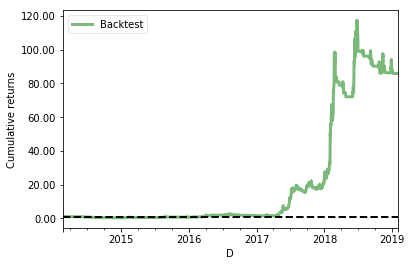

In [136]:
plot_rolling_returns(returns)
plt.show()

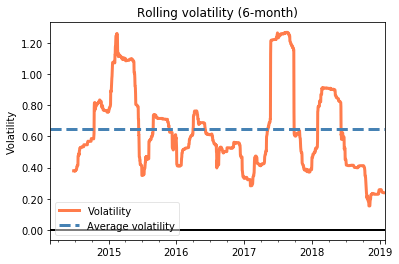

In [137]:
plot_rolling_volatility(returns)
plt.show()

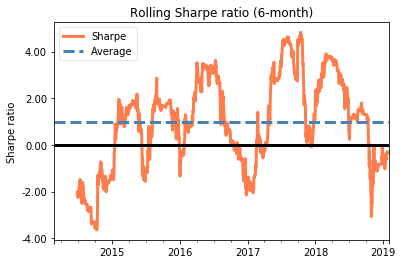

In [138]:
plot_rolling_sharpe(returns)
plt.show()

In [139]:
# As a benchmark, let
returns.describe()

count    1806.000000
mean        0.003346
std         0.043076
min        -0.297616
25%        -0.004438
50%         0.000000
75%         0.006786
max         0.626911
Name: Return, dtype: float64

In [162]:
#Creating a randomized benchmark fake returns set
import random
sampl = np.random.uniform(low=-0.62, high=0.62, size=(1806,))

In [163]:
random_bm = pd.DataFrame(sampl, columns=['Return'])

In [164]:
random_bm.describe()

,Return
count,1806.000000
mean,-0.003825
std,0.356386
min,-0.619208
25%,-0.310684
50%,-0.006262
75%,0.303334
max,0.619318


In [165]:
random_bm = random_bm.assign(D=date)

In [166]:
random_bm.head()

,Return,D
0,0.400678,2014-02-21
1,-0.178405,2014-02-22
2,-0.326422,2014-02-23
3,0.605546,2014-02-24
4,-0.505834,2014-02-25


In [167]:
random_bm.set_index('D', inplace=True)

In [171]:
random = random_bm.Return

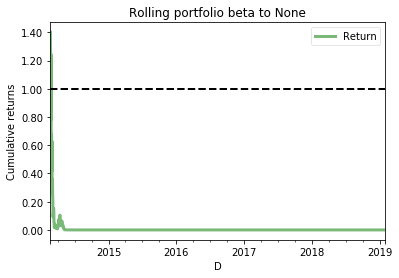

In [173]:
plot_rolling_returns(random_bm)
plt.show()

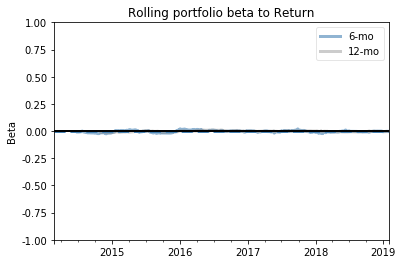

In [174]:
plot_rolling_beta(returns, random)
plt.show()

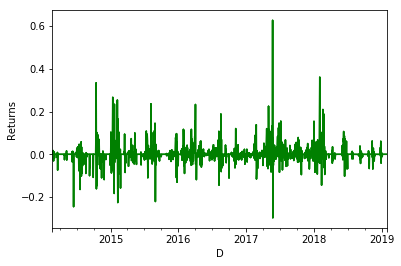

In [186]:
plot_returns(returns)
plt.show()

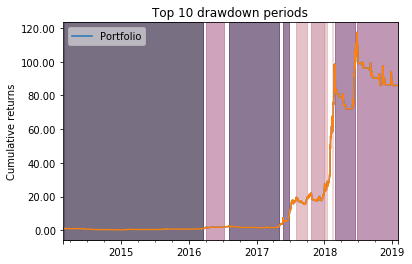

In [176]:
plot_drawdown_periods(returns)
plt.show()

In [179]:
show_worst_drawdown_periods(returns)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,82.07,2014-02-26,2015-01-08,2016-03-16,536
1,47.97,2016-08-06,2017-01-31,2017-05-03,193
2,29.76,2017-05-23,2017-05-24,2017-06-23,24
3,26.90,2018-02-27,2018-04-26,2018-06-14,78
4,26.89,2018-06-25,2019-01-04,NaT,NaN


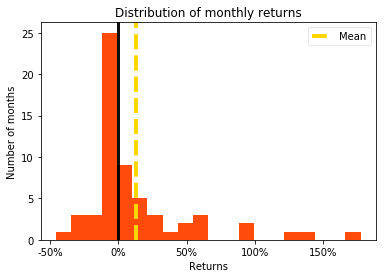

In [178]:
plot_monthly_returns_dist(returns)
plt.show()

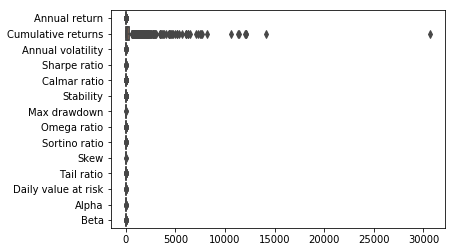

In [182]:
plot_perf_stats(returns, random)
plt.show()

In [184]:
show_perf_stats(returns, random)

Start date,2014-02-21
End date,2019-01-31
Total months,86
,Backtest
Annual return,86.2%
Cumulative returns,8494.0%
Annual volatility,68.4%
Sharpe ratio,1.23
Calmar ratio,1.05
Stability,0.84
Max drawdown,-82.1%


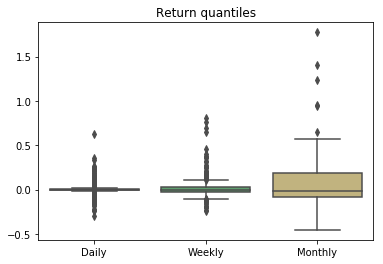

In [188]:
%matplotlib inline
plot_return_quantiles(returns)


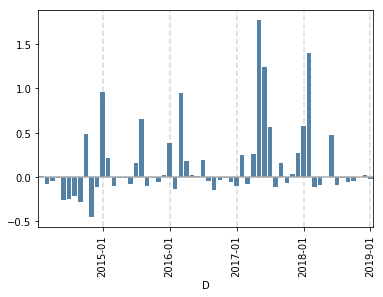

In [189]:
plot_monthly_returns_timeseries(returns)

In [190]:
# Need a position CSV

# Need a transactions (trades) CSV for other plots


In [192]:
# %load tears.py
#
# Copyright 2018 Quantopian, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from __future__ import division

import warnings
from time import time

import empyrical as ep
from IPython.display import display, Markdown
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

import seaborn as sns
from pyfolio import capacity
from pyfolio import perf_attrib
from pyfolio import plotting
from pyfolio import pos
from pyfolio import risk
from pyfolio import round_trips
from pyfolio import timeseries
from pyfolio import txn
from pyfolio import utils

try:
    from . import bayesian
    have_bayesian = True
except ImportError:
    warnings.warn(
        "Could not import bayesian submodule due to missing pymc3 dependency.",
        ImportWarning)
    have_bayesian = False

FACTOR_PARTITIONS = {
    'style': ['momentum', 'size', 'value', 'reversal_short_term',
              'volatility'],
    'sector': ['basic_materials', 'consumer_cyclical', 'financial_services',
               'real_estate', 'consumer_defensive', 'health_care',
               'utilities', 'communication_services', 'energy', 'industrials',
               'technology']
}


def timer(msg_body, previous_time):
    current_time = time()
    run_time = current_time - previous_time
    message = "\nFinished " + msg_body + " (required {:.2f} seconds)."
    print(message.format(run_time))

    return current_time


def create_full_tear_sheet(returns,
                           positions=None,
                           transactions=None,
                           market_data=None,
                           benchmark_rets=None,
                           slippage=None,
                           live_start_date=None,
                           sector_mappings=None,
                           bayesian=False,
                           round_trips=False,
                           estimate_intraday='infer',
                           hide_positions=False,
                           cone_std=(1.0, 1.5, 2.0),
                           bootstrap=False,
                           unadjusted_returns=None,
                           style_factor_panel=None,
                           sectors=None,
                           caps=None,
                           shares_held=None,
                           volumes=None,
                           percentile=None,
                           turnover_denom='AGB',
                           set_context=True,
                           factor_returns=None,
                           factor_loadings=None,
                           pos_in_dollars=True,
                           header_rows=None,
                           factor_partitions=FACTOR_PARTITIONS):
    """
    Generate a number of tear sheets that are useful
    for analyzing a strategy's performance.

    - Fetches benchmarks if needed.
    - Creates tear sheets for returns, and significant events.
        If possible, also creates tear sheets for position analysis,
        transaction analysis, and Bayesian analysis.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - Time series with decimal returns.
         - Example:
            2015-07-16    -0.012143
            2015-07-17    0.045350
            2015-07-20    0.030957
            2015-07-21    0.004902
    positions : pd.DataFrame, optional
        Daily net position values.
         - Time series of dollar amount invested in each position and cash.
         - Days where stocks are not held can be represented by 0 or NaN.
         - Non-working capital is labelled 'cash'
         - Example:
            index         'AAPL'         'MSFT'          cash
            2004-01-09    13939.3800     -14012.9930     711.5585
            2004-01-12    14492.6300     -14624.8700     27.1821
            2004-01-13    -13853.2800    13653.6400      -43.6375
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - One row per trade.
        - Trades on different names that occur at the
          same time will have identical indicies.
        - Example:
            index                  amount   price    symbol
            2004-01-09 12:18:01    483      324.12   'AAPL'
            2004-01-09 12:18:01    122      83.10    'MSFT'
            2004-01-13 14:12:23    -75      340.43   'AAPL'
    market_data : pd.Panel, optional
        Panel with items axis of 'price' and 'volume' DataFrames.
        The major and minor axes should match those of the
        the passed positions DataFrame (same dates and symbols).
    slippage : int/float, optional
        Basis points of slippage to apply to returns before generating
        tearsheet stats and plots.
        If a value is provided, slippage parameter sweep
        plots will be generated from the unadjusted returns.
        Transactions and positions must also be passed.
        - See txn.adjust_returns_for_slippage for more details.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period. This datetime should be normalized.
    hide_positions : bool, optional
        If True, will not output any symbol names.
    bayesian: boolean, optional
        If True, causes the generation of a Bayesian tear sheet.
    round_trips: boolean, optional
        If True, causes the generation of a round trip tear sheet.
    sector_mappings : dict or pd.Series, optional
        Security identifier to sector mapping.
        Security ids as keys, sectors as values.
    estimate_intraday: boolean or str, optional
        Instead of using the end-of-day positions, use the point in the day
        where we have the most $ invested. This will adjust positions to
        better approximate and represent how an intraday strategy behaves.
        By default, this is 'infer', and an attempt will be made to detect
        an intraday strategy. Specifying this value will prevent detection.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - The cone is a normal distribution with this standard deviation
             centered around a linear regression.
    bootstrap : boolean (optional)
        Whether to perform bootstrap analysis for the performance
        metrics. Takes a few minutes longer.
    turnover_denom : str
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    factor_returns : pd.Dataframe, optional
        Returns by factor, with date as index and factors as columns
    factor_loadings : pd.Dataframe, optional
        Factor loadings for all days in the date range, with date and
        ticker as index, and factors as columns.
    pos_in_dollars : boolean, optional
        indicates whether positions is in dollars
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    set_context : boolean, optional
        If True, set default plotting style context.
         - See plotting.context().
    factor_partitions : dict, optional
        dict specifying how factors should be separated in perf attrib
        factor returns and risk exposures plots
        - See create_perf_attrib_tear_sheet().
    """

    if (unadjusted_returns is None) and (slippage is not None) and\
       (transactions is not None):
        unadjusted_returns = returns.copy()
        returns = txn.adjust_returns_for_slippage(returns, positions,
                                                  transactions, slippage)

    positions = utils.check_intraday(estimate_intraday, returns,
                                     positions, transactions)

    create_returns_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
        live_start_date=live_start_date,
        cone_std=cone_std,
        benchmark_rets=benchmark_rets,
        bootstrap=bootstrap,
        turnover_denom=turnover_denom,
        header_rows=header_rows,
        set_context=set_context)

    create_interesting_times_tear_sheet(returns,
                                        benchmark_rets=benchmark_rets,
                                        set_context=set_context)

    if positions is not None:
        create_position_tear_sheet(returns, positions,
                                   hide_positions=hide_positions,
                                   set_context=set_context,
                                   sector_mappings=sector_mappings,
                                   estimate_intraday=False)

        if transactions is not None:
            create_txn_tear_sheet(returns, positions, transactions,
                                  unadjusted_returns=unadjusted_returns,
                                  estimate_intraday=False,
                                  set_context=set_context)
            if round_trips:
                create_round_trip_tear_sheet(
                    returns=returns,
                    positions=positions,
                    transactions=transactions,
                    sector_mappings=sector_mappings,
                    estimate_intraday=False)

            if market_data is not None:
                create_capacity_tear_sheet(returns, positions, transactions,
                                           market_data,
                                           liquidation_daily_vol_limit=0.2,
                                           last_n_days=125,
                                           estimate_intraday=False)

        if style_factor_panel is not None:
            create_risk_tear_sheet(positions, style_factor_panel, sectors,
                                   caps, shares_held, volumes, percentile)

        if factor_returns is not None and factor_loadings is not None:
            create_perf_attrib_tear_sheet(returns, positions, factor_returns,
                                          factor_loadings, transactions,
                                          pos_in_dollars=pos_in_dollars,
                                          factor_partitions=factor_partitions)

    if bayesian:
        create_bayesian_tear_sheet(returns,
                                   live_start_date=live_start_date,
                                   benchmark_rets=benchmark_rets,
                                   set_context=set_context)


@plotting.customize
def create_simple_tear_sheet(returns,
                             positions=None,
                             transactions=None,
                             benchmark_rets=None,
                             slippage=None,
                             estimate_intraday='infer',
                             live_start_date=None,
                             turnover_denom='AGB',
                             header_rows=None):
    """
    Simpler version of create_full_tear_sheet; generates summary performance
    statistics and important plots as a single image.

    - Plots: cumulative returns, rolling beta, rolling Sharpe, underwater,
        exposure, top 10 holdings, total holdings, long/short holdings,
        daily turnover, transaction time distribution.
    - Never accept market_data input (market_data = None)
    - Never accept sector_mappings input (sector_mappings = None)
    - Never perform bootstrap analysis (bootstrap = False)
    - Never hide posistions on top 10 holdings plot (hide_positions = False)
    - Always use default cone_std (cone_std = (1.0, 1.5, 2.0))

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - Time series with decimal returns.
         - Example:
            2015-07-16    -0.012143
            2015-07-17    0.045350
            2015-07-20    0.030957
            2015-07-21    0.004902
    positions : pd.DataFrame, optional
        Daily net position values.
         - Time series of dollar amount invested in each position and cash.
         - Days where stocks are not held can be represented by 0 or NaN.
         - Non-working capital is labelled 'cash'
         - Example:
            index         'AAPL'         'MSFT'          cash
            2004-01-09    13939.3800     -14012.9930     711.5585
            2004-01-12    14492.6300     -14624.8700     27.1821
            2004-01-13    -13853.2800    13653.6400      -43.6375
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - One row per trade.
        - Trades on different names that occur at the
          same time will have identical indicies.
        - Example:
            index                  amount   price    symbol
            2004-01-09 12:18:01    483      324.12   'AAPL'
            2004-01-09 12:18:01    122      83.10    'MSFT'
            2004-01-13 14:12:23    -75      340.43   'AAPL'
    benchmark_rets : pd.Series, optional
        Daily returns of the benchmark, noncumulative.
    slippage : int/float, optional
        Basis points of slippage to apply to returns before generating
        tearsheet stats and plots.
        If a value is provided, slippage parameter sweep
        plots will be generated from the unadjusted returns.
        Transactions and positions must also be passed.
        - See txn.adjust_returns_for_slippage for more details.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period. This datetime should be normalized.
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    set_context : boolean, optional
        If True, set default plotting style context.
    """

    positions = utils.check_intraday(estimate_intraday, returns,
                                     positions, transactions)

    if (slippage is not None) and (transactions is not None):
        returns = txn.adjust_returns_for_slippage(returns, positions,
                                                  transactions, slippage)

    always_sections = 4
    positions_sections = 4 if positions is not None else 0
    transactions_sections = 2 if transactions is not None else 0
    live_sections = 1 if live_start_date is not None else 0
    benchmark_sections = 1 if benchmark_rets is not None else 0

    vertical_sections = sum([
        always_sections,
        positions_sections,
        transactions_sections,
        live_sections,
        benchmark_sections,
    ])

    if live_start_date is not None:
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)

    plotting.show_perf_stats(returns,
                             benchmark_rets,
                             positions=positions,
                             transactions=transactions,
                             turnover_denom=turnover_denom,
                             live_start_date=live_start_date,
                             header_rows=header_rows)

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)

    ax_rolling_returns = plt.subplot(gs[:2, :])
    i = 2
    if benchmark_rets is not None:
        ax_rolling_beta = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
        i += 1
    ax_rolling_sharpe = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_underwater = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1

    plotting.plot_rolling_returns(returns,
                                  factor_returns=benchmark_rets,
                                  live_start_date=live_start_date,
                                  cone_std=(1.0, 1.5, 2.0),
                                  ax=ax_rolling_returns)
    ax_rolling_returns.set_title('Cumulative returns')

    if benchmark_rets is not None:
        plotting.plot_rolling_beta(returns, benchmark_rets, ax=ax_rolling_beta)

    plotting.plot_rolling_sharpe(returns, ax=ax_rolling_sharpe)

    plotting.plot_drawdown_underwater(returns, ax=ax_underwater)

    if positions is not None:
        # Plot simple positions tear sheet
        ax_exposures = plt.subplot(gs[i, :])
        i += 1
        ax_top_positions = plt.subplot(gs[i, :], sharex=ax_exposures)
        i += 1
        ax_holdings = plt.subplot(gs[i, :], sharex=ax_exposures)
        i += 1
        ax_long_short_holdings = plt.subplot(gs[i, :])
        i += 1

        positions_alloc = pos.get_percent_alloc(positions)

        plotting.plot_exposures(returns, positions, ax=ax_exposures)

        plotting.show_and_plot_top_positions(returns,
                                             positions_alloc,
                                             show_and_plot=0,
                                             hide_positions=False,
                                             ax=ax_top_positions)

        plotting.plot_holdings(returns, positions_alloc, ax=ax_holdings)

        plotting.plot_long_short_holdings(returns, positions_alloc,
                                          ax=ax_long_short_holdings)

        if transactions is not None:
            # Plot simple transactions tear sheet
            ax_turnover = plt.subplot(gs[i, :])
            i += 1
            ax_txn_timings = plt.subplot(gs[i, :])
            i += 1

            plotting.plot_turnover(returns,
                                   transactions,
                                   positions,
                                   ax=ax_turnover)

            plotting.plot_txn_time_hist(transactions, ax=ax_txn_timings)

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    plt.close(fig)


@plotting.customize
def create_returns_tear_sheet(returns, positions=None,
                              transactions=None,
                              live_start_date=None,
                              cone_std=(1.0, 1.5, 2.0),
                              benchmark_rets=None,
                              bootstrap=False,
                              turnover_denom='AGB',
                              header_rows=None,
                              return_fig=False):
    """
    Generate a number of plots for analyzing a strategy's returns.

    - Fetches benchmarks, then creates the plots on a single figure.
    - Plots: rolling returns (with cone), rolling beta, rolling sharpe,
        rolling Fama-French risk factors, drawdowns, underwater plot, monthly
        and annual return plots, daily similarity plots,
        and return quantile box plot.
    - Will also print the start and end dates of the strategy,
        performance statistics, drawdown periods, and the return range.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - See full explanation in create_full_tear_sheet.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - The cone is a normal distribution with this standard deviation
             centered around a linear regression.
    benchmark_rets : pd.Series, optional
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    bootstrap : boolean, optional
        Whether to perform bootstrap analysis for the performance
        metrics. Takes a few minutes longer.
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    if benchmark_rets is not None:
        returns = utils.clip_returns_to_benchmark(returns, benchmark_rets)

    plotting.show_perf_stats(returns, benchmark_rets,
                             positions=positions,
                             transactions=transactions,
                             turnover_denom=turnover_denom,
                             bootstrap=bootstrap,
                             live_start_date=live_start_date,
                             header_rows=header_rows)

    plotting.show_worst_drawdown_periods(returns)

    vertical_sections = 11

    if live_start_date is not None:
        vertical_sections += 1
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)

    if benchmark_rets is not None:
        vertical_sections += 1

    if bootstrap:
        vertical_sections += 1

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)
    ax_rolling_returns = plt.subplot(gs[:2, :])

    i = 2
    ax_rolling_returns_vol_match = plt.subplot(gs[i, :],
                                               sharex=ax_rolling_returns)
    i += 1
    ax_rolling_returns_log = plt.subplot(gs[i, :],
                                         sharex=ax_rolling_returns)
    i += 1
    ax_returns = plt.subplot(gs[i, :],
                             sharex=ax_rolling_returns)
    i += 1
    if benchmark_rets is not None:
        ax_rolling_beta = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
        i += 1
    ax_rolling_volatility = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_sharpe = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_drawdown = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_underwater = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_monthly_heatmap = plt.subplot(gs[i, 0])
    ax_annual_returns = plt.subplot(gs[i, 1])
    ax_monthly_dist = plt.subplot(gs[i, 2])
    i += 1
    ax_return_quantiles = plt.subplot(gs[i, :])
    i += 1

    plotting.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns)
    ax_rolling_returns.set_title(
        'Cumulative returns')

    plotting.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=None,
        volatility_match=(benchmark_rets is not None),
        legend_loc=None,
        ax=ax_rolling_returns_vol_match)
    ax_rolling_returns_vol_match.set_title(
        'Cumulative returns volatility matched to benchmark')

    plotting.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        logy=True,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns_log)
    ax_rolling_returns_log.set_title(
        'Cumulative returns on logarithmic scale')

    plotting.plot_returns(
        returns,
        live_start_date=live_start_date,
        ax=ax_returns,
    )
    ax_returns.set_title(
        'Returns')

    if benchmark_rets is not None:
        plotting.plot_rolling_beta(
            returns, benchmark_rets, ax=ax_rolling_beta)

    plotting.plot_rolling_volatility(
        returns, factor_returns=benchmark_rets, ax=ax_rolling_volatility)

    plotting.plot_rolling_sharpe(
        returns, ax=ax_rolling_sharpe)

    # Drawdowns
    plotting.plot_drawdown_periods(
        returns, top=5, ax=ax_drawdown)

    plotting.plot_drawdown_underwater(
        returns=returns, ax=ax_underwater)

    plotting.plot_monthly_returns_heatmap(returns, ax=ax_monthly_heatmap)
    plotting.plot_annual_returns(returns, ax=ax_annual_returns)
    plotting.plot_monthly_returns_dist(returns, ax=ax_monthly_dist)

    plotting.plot_return_quantiles(
        returns,
        live_start_date=live_start_date,
        ax=ax_return_quantiles)

    if bootstrap and benchmark_rets is not None:
        ax_bootstrap = plt.subplot(gs[i, :])
        plotting.plot_perf_stats(returns, benchmark_rets,
                                 ax=ax_bootstrap)
    elif bootstrap:
        raise ValueError('bootstrap requires passing of benchmark_rets.')

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


@plotting.customize
def create_position_tear_sheet(returns, positions,
                               show_and_plot_top_pos=2, hide_positions=False,
                               return_fig=False, sector_mappings=None,
                               transactions=None, estimate_intraday='infer'):
    """
    Generate a number of plots for analyzing a
    strategy's positions and holdings.

    - Plots: gross leverage, exposures, top positions, and holdings.
    - Will also print the top positions held.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    show_and_plot_top_pos : int, optional
        By default, this is 2, and both prints and plots the
        top 10 positions.
        If this is 0, it will only plot; if 1, it will only print.
    hide_positions : bool, optional
        If True, will not output any symbol names.
        Overrides show_and_plot_top_pos to 0 to suppress text output.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    sector_mappings : dict or pd.Series, optional
        Security identifier to sector mapping.
        Security ids as keys, sectors as values.
    transactions : pd.DataFrame, optional
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in create_full_tear_sheet.
    estimate_intraday: boolean or str, optional
        Approximate returns for intraday strategies.
        See description in create_full_tear_sheet.
    """

    positions = utils.check_intraday(estimate_intraday, returns,
                                     positions, transactions)

    if hide_positions:
        show_and_plot_top_pos = 0
    vertical_sections = 7 if sector_mappings is not None else 6

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)
    ax_exposures = plt.subplot(gs[0, :])
    ax_top_positions = plt.subplot(gs[1, :], sharex=ax_exposures)
    ax_max_median_pos = plt.subplot(gs[2, :], sharex=ax_exposures)
    ax_holdings = plt.subplot(gs[3, :], sharex=ax_exposures)
    ax_long_short_holdings = plt.subplot(gs[4, :])
    ax_gross_leverage = plt.subplot(gs[5, :], sharex=ax_exposures)

    positions_alloc = pos.get_percent_alloc(positions)

    plotting.plot_exposures(returns, positions, ax=ax_exposures)

    plotting.show_and_plot_top_positions(
        returns,
        positions_alloc,
        show_and_plot=show_and_plot_top_pos,
        hide_positions=hide_positions,
        ax=ax_top_positions)

    plotting.plot_max_median_position_concentration(positions,
                                                    ax=ax_max_median_pos)

    plotting.plot_holdings(returns, positions_alloc, ax=ax_holdings)

    plotting.plot_long_short_holdings(returns, positions_alloc,
                                      ax=ax_long_short_holdings)

    plotting.plot_gross_leverage(returns, positions,
                                 ax=ax_gross_leverage)

    if sector_mappings is not None:
        sector_exposures = pos.get_sector_exposures(positions,
                                                    sector_mappings)
        if len(sector_exposures.columns) > 1:
            sector_alloc = pos.get_percent_alloc(sector_exposures)
            sector_alloc = sector_alloc.drop('cash', axis='columns')
            ax_sector_alloc = plt.subplot(gs[6, :], sharex=ax_exposures)
            plotting.plot_sector_allocations(returns, sector_alloc,
                                             ax=ax_sector_alloc)

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


@plotting.customize
def create_txn_tear_sheet(returns, positions, transactions,
                          unadjusted_returns=None, estimate_intraday='infer',
                          return_fig=False):
    """
    Generate a number of plots for analyzing a strategy's transactions.

    Plots: turnover, daily volume, and a histogram of daily volume.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in create_full_tear_sheet.
    unadjusted_returns : pd.Series, optional
        Daily unadjusted returns of the strategy, noncumulative.
        Will plot additional swippage sweep analysis.
         - See pyfolio.plotting.plot_swippage_sleep and
           pyfolio.plotting.plot_slippage_sensitivity
    estimate_intraday: boolean or str, optional
        Approximate returns for intraday strategies.
        See description in create_full_tear_sheet.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    positions = utils.check_intraday(estimate_intraday, returns,
                                     positions, transactions)

    vertical_sections = 6 if unadjusted_returns is not None else 4

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)
    ax_turnover = plt.subplot(gs[0, :])
    ax_daily_volume = plt.subplot(gs[1, :], sharex=ax_turnover)
    ax_turnover_hist = plt.subplot(gs[2, :])
    ax_txn_timings = plt.subplot(gs[3, :])

    plotting.plot_turnover(
        returns,
        transactions,
        positions,
        ax=ax_turnover)

    plotting.plot_daily_volume(returns, transactions, ax=ax_daily_volume)

    try:
        plotting.plot_daily_turnover_hist(transactions, positions,
                                          ax=ax_turnover_hist)
    except ValueError:
        warnings.warn('Unable to generate turnover plot.', UserWarning)

    plotting.plot_txn_time_hist(transactions, ax=ax_txn_timings)

    if unadjusted_returns is not None:
        ax_slippage_sweep = plt.subplot(gs[4, :])
        plotting.plot_slippage_sweep(unadjusted_returns,
                                     positions,
                                     transactions,
                                     ax=ax_slippage_sweep
                                     )
        ax_slippage_sensitivity = plt.subplot(gs[5, :])
        plotting.plot_slippage_sensitivity(unadjusted_returns,
                                           positions,
                                           transactions,
                                           ax=ax_slippage_sensitivity
                                           )
    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


@plotting.customize
def create_round_trip_tear_sheet(returns, positions, transactions,
                                 sector_mappings=None,
                                 estimate_intraday='infer', return_fig=False):
    """
    Generate a number of figures and plots describing the duration,
    frequency, and profitability of trade "round trips."
    A round trip is started when a new long or short position is
    opened and is only completed when the number of shares in that
    position returns to or crosses zero.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in create_full_tear_sheet.
    sector_mappings : dict or pd.Series, optional
        Security identifier to sector mapping.
        Security ids as keys, sectors as values.
    estimate_intraday: boolean or str, optional
        Approximate returns for intraday strategies.
        See description in create_full_tear_sheet.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    positions = utils.check_intraday(estimate_intraday, returns,
                                     positions, transactions)

    transactions_closed = round_trips.add_closing_transactions(positions,
                                                               transactions)
    # extract_round_trips requires BoD portfolio_value
    trades = round_trips.extract_round_trips(
        transactions_closed,
        portfolio_value=positions.sum(axis='columns') / (1 + returns)
    )

    if len(trades) < 5:
        warnings.warn(
            """Fewer than 5 round-trip trades made.
               Skipping round trip tearsheet.""", UserWarning)
        return

    round_trips.print_round_trip_stats(trades)

    plotting.show_profit_attribution(trades)

    if sector_mappings is not None:
        sector_trades = round_trips.apply_sector_mappings_to_round_trips(
            trades, sector_mappings)
        plotting.show_profit_attribution(sector_trades)

    fig = plt.figure(figsize=(14, 3 * 6))

    gs = gridspec.GridSpec(3, 2, wspace=0.5, hspace=0.5)

    ax_trade_lifetimes = plt.subplot(gs[0, :])
    ax_prob_profit_trade = plt.subplot(gs[1, 0])
    ax_holding_time = plt.subplot(gs[1, 1])
    ax_pnl_per_round_trip_dollars = plt.subplot(gs[2, 0])
    ax_pnl_per_round_trip_pct = plt.subplot(gs[2, 1])

    plotting.plot_round_trip_lifetimes(trades, ax=ax_trade_lifetimes)

    plotting.plot_prob_profit_trade(trades, ax=ax_prob_profit_trade)

    trade_holding_times = [x.days for x in trades['duration']]
    sns.distplot(trade_holding_times, kde=False, ax=ax_holding_time)
    ax_holding_time.set(xlabel='Holding time in days')

    sns.distplot(trades.pnl, kde=False, ax=ax_pnl_per_round_trip_dollars)
    ax_pnl_per_round_trip_dollars.set(xlabel='PnL per round-trip trade in $')

    sns.distplot(trades.returns.dropna() * 100, kde=False,
                 ax=ax_pnl_per_round_trip_pct)
    ax_pnl_per_round_trip_pct.set(
        xlabel='Round-trip returns in %')

    gs.tight_layout(fig)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


@plotting.customize
def create_interesting_times_tear_sheet(
        returns, benchmark_rets=None, legend_loc='best', return_fig=False):
    """
    Generate a number of returns plots around interesting points in time,
    like the flash crash and 9/11.

    Plots: returns around the dotcom bubble burst, Lehmann Brothers' failure,
    9/11, US downgrade and EU debt crisis, Fukushima meltdown, US housing
    bubble burst, EZB IR, Great Recession (August 2007, March and September
    of 2008, Q1 & Q2 2009), flash crash, April and October 2014.

    benchmark_rets must be passed, as it is meaningless to analyze performance
    during interesting times without some benchmark to refer to.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    benchmark_rets : pd.Series
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    legend_loc : plt.legend_loc, optional
         The legend's location.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    rets_interesting = timeseries.extract_interesting_date_ranges(returns)

    if not rets_interesting:
        warnings.warn('Passed returns do not overlap with any'
                      'interesting times.', UserWarning)
        return

    utils.print_table(pd.DataFrame(rets_interesting)
                      .describe().transpose()
                      .loc[:, ['mean', 'min', 'max']] * 100,
                      name='Stress Events',
                      float_format='{0:.2f}%'.format)

    if benchmark_rets is not None:
        returns = utils.clip_returns_to_benchmark(returns, benchmark_rets)

        bmark_interesting = timeseries.extract_interesting_date_ranges(
            benchmark_rets)

    num_plots = len(rets_interesting)
    # 2 plots, 1 row; 3 plots, 2 rows; 4 plots, 2 rows; etc.
    num_rows = int((num_plots + 1) / 2.0)
    fig = plt.figure(figsize=(14, num_rows * 6.0))
    gs = gridspec.GridSpec(num_rows, 2, wspace=0.5, hspace=0.5)

    for i, (name, rets_period) in enumerate(rets_interesting.items()):
        # i=0 -> 0, i=1 -> 0, i=2 -> 1 ;; i=0 -> 0, i=1 -> 1, i=2 -> 0
        ax = plt.subplot(gs[int(i / 2.0), i % 2])

        ep.cum_returns(rets_period).plot(
            ax=ax, color='forestgreen', label='algo', alpha=0.7, lw=2)

        if benchmark_rets is not None:
            ep.cum_returns(bmark_interesting[name]).plot(
                ax=ax, color='gray', label='benchmark', alpha=0.6)
            ax.legend(['Algo',
                       'benchmark'],
                      loc=legend_loc, frameon=True, framealpha=0.5)
        else:
            ax.legend(['Algo'],
                      loc=legend_loc, frameon=True, framealpha=0.5)

        ax.set_title(name)
        ax.set_ylabel('Returns')
        ax.set_xlabel('')

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


@plotting.customize
def create_capacity_tear_sheet(returns, positions, transactions,
                               market_data,
                               liquidation_daily_vol_limit=0.2,
                               trade_daily_vol_limit=0.05,
                               last_n_days=utils.APPROX_BDAYS_PER_MONTH * 6,
                               days_to_liquidate_limit=1,
                               estimate_intraday='infer'):
    """
    Generates a report detailing portfolio size constraints set by
    least liquid tickers. Plots a "capacity sweep," a curve describing
    projected sharpe ratio given the slippage penalties that are
    applied at various capital bases.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in create_full_tear_sheet.
    market_data : pd.Panel
        Panel with items axis of 'price' and 'volume' DataFrames.
        The major and minor axes should match those of the
        the passed positions DataFrame (same dates and symbols).
    liquidation_daily_vol_limit : float
        Max proportion of a daily bar that can be consumed in the
        process of liquidating a position in the
        "days to liquidation" analysis.
    trade_daily_vol_limit : float
        Flag daily transaction totals that exceed proportion of
        daily bar.
    last_n_days : integer
        Compute max position allocation and dollar volume for only
        the last N days of the backtest
    days_to_liquidate_limit : integer
        Display all tickers with greater max days to liquidation.
    estimate_intraday: boolean or str, optional
        Approximate returns for intraday strategies.
        See description in create_full_tear_sheet.
    """

    positions = utils.check_intraday(estimate_intraday, returns,
                                     positions, transactions)

    print("Max days to liquidation is computed for each traded name "
          "assuming a 20% limit on daily bar consumption \n"
          "and trailing 5 day mean volume as the available bar volume.\n\n"
          "Tickers with >1 day liquidation time at a"
          " constant $1m capital base:")

    max_days_by_ticker = capacity.get_max_days_to_liquidate_by_ticker(
        positions, market_data,
        max_bar_consumption=liquidation_daily_vol_limit,
        capital_base=1e6,
        mean_volume_window=5)
    max_days_by_ticker.index = (
        max_days_by_ticker.index.map(utils.format_asset))

    print("Whole backtest:")
    utils.print_table(
        max_days_by_ticker[max_days_by_ticker.days_to_liquidate >
                           days_to_liquidate_limit])

    max_days_by_ticker_lnd = capacity.get_max_days_to_liquidate_by_ticker(
        positions, market_data,
        max_bar_consumption=liquidation_daily_vol_limit,
        capital_base=1e6,
        mean_volume_window=5,
        last_n_days=last_n_days)
    max_days_by_ticker_lnd.index = (
        max_days_by_ticker_lnd.index.map(utils.format_asset))

    print("Last {} trading days:".format(last_n_days))
    utils.print_table(
        max_days_by_ticker_lnd[max_days_by_ticker_lnd.days_to_liquidate > 1])

    llt = capacity.get_low_liquidity_transactions(transactions, market_data)
    llt.index = llt.index.map(utils.format_asset)

    print('Tickers with daily transactions consuming >{}% of daily bar \n'
          'all backtest:'.format(trade_daily_vol_limit * 100))
    utils.print_table(
        llt[llt['max_pct_bar_consumed'] > trade_daily_vol_limit * 100])

    llt = capacity.get_low_liquidity_transactions(
        transactions, market_data, last_n_days=last_n_days)

    print("Last {} trading days:".format(last_n_days))
    utils.print_table(
        llt[llt['max_pct_bar_consumed'] > trade_daily_vol_limit * 100])

    bt_starting_capital = positions.iloc[0].sum() / (1 + returns.iloc[0])
    fig, ax_capacity_sweep = plt.subplots(figsize=(14, 6))
    plotting.plot_capacity_sweep(returns, transactions, market_data,
                                 bt_starting_capital,
                                 min_pv=100000,
                                 max_pv=300000000,
                                 step_size=1000000,
                                 ax=ax_capacity_sweep)


@plotting.customize
def create_bayesian_tear_sheet(returns, benchmark_rets=None,
                               live_start_date=None, samples=2000,
                               return_fig=False, stoch_vol=False,
                               progressbar=True):
    """
    Generate a number of Bayesian distributions and a Bayesian
    cone plot of returns.

    Plots: Sharpe distribution, annual volatility distribution,
    annual alpha distribution, beta distribution, predicted 1 and 5
    day returns distributions, and a cumulative returns cone plot.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    benchmark_rets : pd.Series, optional
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    live_start_date : datetime, optional
        The point in time when the strategy began live
        trading, after its backtest period.
    samples : int, optional
        Number of posterior samples to draw.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    stoch_vol : boolean, optional
        If True, run and plot the stochastic volatility model
    progressbar : boolean, optional
        If True, show a progress bar
    """

    if not have_bayesian:
        raise NotImplementedError(
            "Bayesian tear sheet requirements not found.\n"
            "Run 'pip install pyfolio[bayesian]' to install "
            "bayesian requirements."
        )

    if live_start_date is None:
        raise NotImplementedError(
            'Bayesian tear sheet requires setting of live_start_date'
        )

    live_start_date = ep.utils.get_utc_timestamp(live_start_date)
    df_train = returns.loc[returns.index < live_start_date]
    df_test = returns.loc[returns.index >= live_start_date]

    # Run T model with missing data
    print("Running T model")
    previous_time = time()
    # track the total run time of the Bayesian tear sheet
    start_time = previous_time

    trace_t, ppc_t = bayesian.run_model('t', df_train,
                                        returns_test=df_test,
                                        samples=samples, ppc=True,
                                        progressbar=progressbar)
    previous_time = timer("T model", previous_time)

    # Compute BEST model
    print("\nRunning BEST model")
    trace_best = bayesian.run_model('best', df_train,
                                    returns_test=df_test,
                                    samples=samples,
                                    progressbar=progressbar)
    previous_time = timer("BEST model", previous_time)

    # Plot results

    fig = plt.figure(figsize=(14, 10 * 2))
    gs = gridspec.GridSpec(9, 2, wspace=0.3, hspace=0.3)

    axs = []
    row = 0

    # Plot Bayesian cone
    ax_cone = plt.subplot(gs[row, :])
    bayesian.plot_bayes_cone(df_train, df_test, ppc_t, ax=ax_cone)
    previous_time = timer("plotting Bayesian cone", previous_time)

    # Plot BEST results
    row += 1
    axs.append(plt.subplot(gs[row, 0]))
    axs.append(plt.subplot(gs[row, 1]))
    row += 1
    axs.append(plt.subplot(gs[row, 0]))
    axs.append(plt.subplot(gs[row, 1]))
    row += 1
    axs.append(plt.subplot(gs[row, 0]))
    axs.append(plt.subplot(gs[row, 1]))
    row += 1
    # Effect size across two
    axs.append(plt.subplot(gs[row, :]))

    bayesian.plot_best(trace=trace_best, axs=axs)
    previous_time = timer("plotting BEST results", previous_time)

    # Compute Bayesian predictions
    row += 1
    ax_ret_pred_day = plt.subplot(gs[row, 0])
    ax_ret_pred_week = plt.subplot(gs[row, 1])
    day_pred = ppc_t[:, 0]
    p5 = scipy.stats.scoreatpercentile(day_pred, 5)
    sns.distplot(day_pred,
                 ax=ax_ret_pred_day
                 )
    ax_ret_pred_day.axvline(p5, linestyle='--', linewidth=3.)
    ax_ret_pred_day.set_xlabel('Predicted returns 1 day')
    ax_ret_pred_day.set_ylabel('Frequency')
    ax_ret_pred_day.text(0.4, 0.9, 'Bayesian VaR = %.2f' % p5,
                         verticalalignment='bottom',
                         horizontalalignment='right',
                         transform=ax_ret_pred_day.transAxes)
    previous_time = timer("computing Bayesian predictions", previous_time)

    # Plot Bayesian VaRs
    week_pred = (
        np.cumprod(ppc_t[:, :5] + 1, 1) - 1)[:, -1]
    p5 = scipy.stats.scoreatpercentile(week_pred, 5)
    sns.distplot(week_pred,
                 ax=ax_ret_pred_week
                 )
    ax_ret_pred_week.axvline(p5, linestyle='--', linewidth=3.)
    ax_ret_pred_week.set_xlabel('Predicted cum returns 5 days')
    ax_ret_pred_week.set_ylabel('Frequency')
    ax_ret_pred_week.text(0.4, 0.9, 'Bayesian VaR = %.2f' % p5,
                          verticalalignment='bottom',
                          horizontalalignment='right',
                          transform=ax_ret_pred_week.transAxes)
    previous_time = timer("plotting Bayesian VaRs estimate", previous_time)

    # Run alpha beta model
    if benchmark_rets is not None:
        print("\nRunning alpha beta model")
        benchmark_rets = benchmark_rets.loc[df_train.index]
        trace_alpha_beta = bayesian.run_model('alpha_beta', df_train,
                                              bmark=benchmark_rets,
                                              samples=samples,
                                              progressbar=progressbar)
        previous_time = timer("running alpha beta model", previous_time)

        # Plot alpha and beta
        row += 1
        ax_alpha = plt.subplot(gs[row, 0])
        ax_beta = plt.subplot(gs[row, 1])
        sns.distplot((1 + trace_alpha_beta['alpha'][100:])**252 - 1,
                     ax=ax_alpha)
        sns.distplot(trace_alpha_beta['beta'][100:], ax=ax_beta)
        ax_alpha.set_xlabel('Annual Alpha')
        ax_alpha.set_ylabel('Belief')
        ax_beta.set_xlabel('Beta')
        ax_beta.set_ylabel('Belief')
        previous_time = timer("plotting alpha beta model", previous_time)

    if stoch_vol:
        # run stochastic volatility model
        returns_cutoff = 400
        print(
            "\nRunning stochastic volatility model on "
            "most recent {} days of returns.".format(returns_cutoff)
        )
        if df_train.size > returns_cutoff:
            df_train_truncated = df_train[-returns_cutoff:]
        _, trace_stoch_vol = bayesian.model_stoch_vol(df_train_truncated)
        previous_time = timer(
            "running stochastic volatility model", previous_time)

        # plot latent volatility
        row += 1
        ax_volatility = plt.subplot(gs[row, :])
        bayesian.plot_stoch_vol(
            df_train_truncated, trace=trace_stoch_vol, ax=ax_volatility)
        previous_time = timer(
            "plotting stochastic volatility model", previous_time)

    total_time = time() - start_time
    print("\nTotal runtime was {:.2f} seconds.".format(total_time))

    gs.tight_layout(fig)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


@plotting.customize
def create_risk_tear_sheet(positions,
                           style_factor_panel=None,
                           sectors=None,
                           caps=None,
                           shares_held=None,
                           volumes=None,
                           percentile=None,
                           returns=None,
                           transactions=None,
                           estimate_intraday='infer',
                           return_fig=False):
    '''
    Creates risk tear sheet: computes and plots style factor exposures, sector
    exposures, market cap exposures and volume exposures.

    Parameters
    ----------
    positions : pd.DataFrame
        Daily equity positions of algorithm, in dollars.
        - DataFrame with dates as index, equities as columns
        - Last column is cash held
        - Example:
                     Equity(24   Equity(62
                       [AAPL])      [ABT])             cash
        2017-04-03	-108062.40 	  4401.540     2.247757e+07
        2017-04-04	-108852.00	  4373.820     2.540999e+07
        2017-04-05	-119968.66	  4336.200     2.839812e+07

    style_factor_panel : pd.Panel
        Panel where each item is a DataFrame that tabulates style factor per
        equity per day.
        - Each item has dates as index, equities as columns
        - Example item:
                     Equity(24   Equity(62
                       [AAPL])      [ABT])
        2017-04-03	  -0.51284     1.39173
        2017-04-04	  -0.73381     0.98149
        2017-04-05	  -0.90132	   1.13981

    sectors : pd.DataFrame
        Daily Morningstar sector code per asset
        - DataFrame with dates as index and equities as columns
        - Example:
                     Equity(24   Equity(62
                       [AAPL])      [ABT])
        2017-04-03	     311.0       206.0
        2017-04-04	     311.0       206.0
        2017-04-05	     311.0	     206.0

    caps : pd.DataFrame
        Daily market cap per asset
        - DataFrame with dates as index and equities as columns
        - Example:
                          Equity(24        Equity(62
                            [AAPL])           [ABT])
        2017-04-03     1.327160e+10     6.402460e+10
        2017-04-04	   1.329620e+10     6.403694e+10
        2017-04-05	   1.297464e+10	    6.397187e+10

    shares_held : pd.DataFrame
        Daily number of shares held by an algorithm.
        - Example:
                          Equity(24        Equity(62
                            [AAPL])           [ABT])
        2017-04-03             1915            -2595
        2017-04-04	           1968            -3272
        2017-04-05	           2104            -3917

    volumes : pd.DataFrame
        Daily volume per asset
        - DataFrame with dates as index and equities as columns
        - Example:
                          Equity(24        Equity(62
                            [AAPL])           [ABT])
        2017-04-03      34940859.00       4665573.80
        2017-04-04	    35603329.10       4818463.90
        2017-04-05	    41846731.75	      4129153.10

    percentile : float
        Percentile to use when computing and plotting volume exposures.
        - Defaults to 10th percentile
    '''

    positions = utils.check_intraday(estimate_intraday, returns,
                                     positions, transactions)

    idx = positions.index & style_factor_panel.iloc[0].index & sectors.index \
        & caps.index & shares_held.index & volumes.index
    positions = positions.loc[idx]

    vertical_sections = 0
    if style_factor_panel is not None:
        vertical_sections += len(style_factor_panel.items)
        new_style_dict = {}
        for item in style_factor_panel.items:
            new_style_dict.update({item:
                                   style_factor_panel.loc[item].loc[idx]})
        style_factor_panel = pd.Panel()
        style_factor_panel = style_factor_panel.from_dict(new_style_dict)
    if sectors is not None:
        vertical_sections += 4
        sectors = sectors.loc[idx]
    if caps is not None:
        vertical_sections += 4
        caps = caps.loc[idx]
    if (shares_held is not None) & (volumes is not None) \
                                 & (percentile is not None):
        vertical_sections += 3
        shares_held = shares_held.loc[idx]
        volumes = volumes.loc[idx]

    if percentile is None:
        percentile = 0.1

    fig = plt.figure(figsize=[14, vertical_sections * 6])
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)

    if style_factor_panel is not None:
        style_axes = []
        style_axes.append(plt.subplot(gs[0, :]))
        for i in range(1, len(style_factor_panel.items)):
            style_axes.append(plt.subplot(gs[i, :], sharex=style_axes[0]))

        j = 0
        for name, df in style_factor_panel.iteritems():
            sfe = risk.compute_style_factor_exposures(positions, df)
            risk.plot_style_factor_exposures(sfe, name, style_axes[j])
            j += 1

    if sectors is not None:
        i += 1
        ax_sector_longshort = plt.subplot(gs[i:i+2, :], sharex=style_axes[0])
        i += 2
        ax_sector_gross = plt.subplot(gs[i, :], sharex=style_axes[0])
        i += 1
        ax_sector_net = plt.subplot(gs[i, :], sharex=style_axes[0])
        long_exposures, short_exposures, gross_exposures, net_exposures \
            = risk.compute_sector_exposures(positions, sectors)
        risk.plot_sector_exposures_longshort(long_exposures, short_exposures,
                                             ax=ax_sector_longshort)
        risk.plot_sector_exposures_gross(gross_exposures, ax=ax_sector_gross)
        risk.plot_sector_exposures_net(net_exposures, ax=ax_sector_net)

    if caps is not None:
        i += 1
        ax_cap_longshort = plt.subplot(gs[i:i+2, :], sharex=style_axes[0])
        i += 2
        ax_cap_gross = plt.subplot(gs[i, :], sharex=style_axes[0])
        i += 1
        ax_cap_net = plt.subplot(gs[i, :], sharex=style_axes[0])
        long_exposures, short_exposures, gross_exposures, net_exposures \
            = risk.compute_cap_exposures(positions, caps)
        risk.plot_cap_exposures_longshort(long_exposures, short_exposures,
                                          ax_cap_longshort)
        risk.plot_cap_exposures_gross(gross_exposures, ax_cap_gross)
        risk.plot_cap_exposures_net(net_exposures, ax_cap_net)

    if volumes is not None:
        i += 1
        ax_vol_longshort = plt.subplot(gs[i:i+2, :], sharex=style_axes[0])
        i += 2
        ax_vol_gross = plt.subplot(gs[i, :], sharex=style_axes[0])
        longed_threshold, shorted_threshold, grossed_threshold \
            = risk.compute_volume_exposures(positions, volumes, percentile)
        risk.plot_volume_exposures_longshort(longed_threshold,
                                             shorted_threshold, percentile,
                                             ax_vol_longshort)
        risk.plot_volume_exposures_gross(grossed_threshold, percentile,
                                         ax_vol_gross)

    plt.show()

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


@plotting.customize
def create_perf_attrib_tear_sheet(returns,
                                  positions,
                                  factor_returns,
                                  factor_loadings,
                                  transactions=None,
                                  pos_in_dollars=True,
                                  return_fig=False,
                                  factor_partitions=FACTOR_PARTITIONS):
    """
    Generate plots and tables for analyzing a strategy's performance.

    Parameters
    ----------
    returns : pd.Series
        Returns for each day in the date range.

    positions: pd.DataFrame
        Daily holdings (in dollars or percentages), indexed by date.
        Will be converted to percentages if positions are in dollars.
        Short positions show up as cash in the 'cash' column.

    factor_returns : pd.DataFrame
        Returns by factor, with date as index and factors as columns

    factor_loadings : pd.DataFrame
        Factor loadings for all days in the date range, with date
        and ticker as index, and factors as columns.

    transactions : pd.DataFrame, optional
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in create_full_tear_sheet.
         - Default is None.

    pos_in_dollars : boolean, optional
        Flag indicating whether `positions` are in dollars or percentages
        If True, positions are in dollars.

    return_fig : boolean, optional
        If True, returns the figure that was plotted on.

    factor_partitions : dict
        dict specifying how factors should be separated in factor returns
        and risk exposures plots
        - Example:
          {'style': ['momentum', 'size', 'value', ...],
           'sector': ['technology', 'materials', ... ]}
    """
    portfolio_exposures, perf_attrib_data = perf_attrib.perf_attrib(
        returns, positions, factor_returns, factor_loadings, transactions,
        pos_in_dollars=pos_in_dollars
    )

    display(Markdown("## Performance Relative to Common Risk Factors"))

    # aggregate perf attrib stats and show summary table
    perf_attrib.show_perf_attrib_stats(returns, positions, factor_returns,
                                       factor_loadings, transactions,
                                       pos_in_dollars)

    # one section for the returns plot, and for each factor grouping
    # one section for factor returns, and one for risk exposures
    vertical_sections = 1 + 2 * max(len(factor_partitions), 1)
    current_section = 0

    fig = plt.figure(figsize=[14, vertical_sections * 6])

    gs = gridspec.GridSpec(vertical_sections, 1,
                           wspace=0.5, hspace=0.5)

    perf_attrib.plot_returns(perf_attrib_data,
                             ax=plt.subplot(gs[current_section]))
    current_section += 1

    if factor_partitions is not None:

        for factor_type, partitions in factor_partitions.iteritems():

            columns_to_select = perf_attrib_data.columns.intersection(
                partitions
            )

            perf_attrib.plot_factor_contribution_to_perf(
                perf_attrib_data[columns_to_select],
                ax=plt.subplot(gs[current_section]),
                title=(
                    'Cumulative common {} returns attribution'
                ).format(factor_type)
            )
            current_section += 1

        for factor_type, partitions in factor_partitions.iteritems():

            perf_attrib.plot_risk_exposures(
                portfolio_exposures[portfolio_exposures.columns
                                    .intersection(partitions)],
                ax=plt.subplot(gs[current_section]),
                title='Daily {} factor exposures'.format(factor_type)
            )
            current_section += 1

    else:

        perf_attrib.plot_factor_contribution_to_perf(
            perf_attrib_data,
            ax=plt.subplot(gs[current_section])
        )
        current_section += 1

        perf_attrib.plot_risk_exposures(
            portfolio_exposures,
            ax=plt.subplot(gs[current_section])
        )

    gs.tight_layout(fig)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


Start date,2014-02-21
End date,2019-01-31
Total months,86
,Backtest
Annual return,86.2%
Cumulative returns,8494.0%
Annual volatility,68.4%
Sharpe ratio,1.23
Calmar ratio,1.05
Stability,0.84
Max drawdown,-82.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,82.07,2014-02-26,2015-01-08,2016-03-16,536
1,47.97,2016-08-06,2017-01-31,2017-05-03,193
2,29.76,2017-05-23,2017-05-24,2017-06-23,24
3,26.90,2018-02-27,2018-04-26,2018-06-14,78
4,26.89,2018-06-25,2019-01-04,NaT,NaN


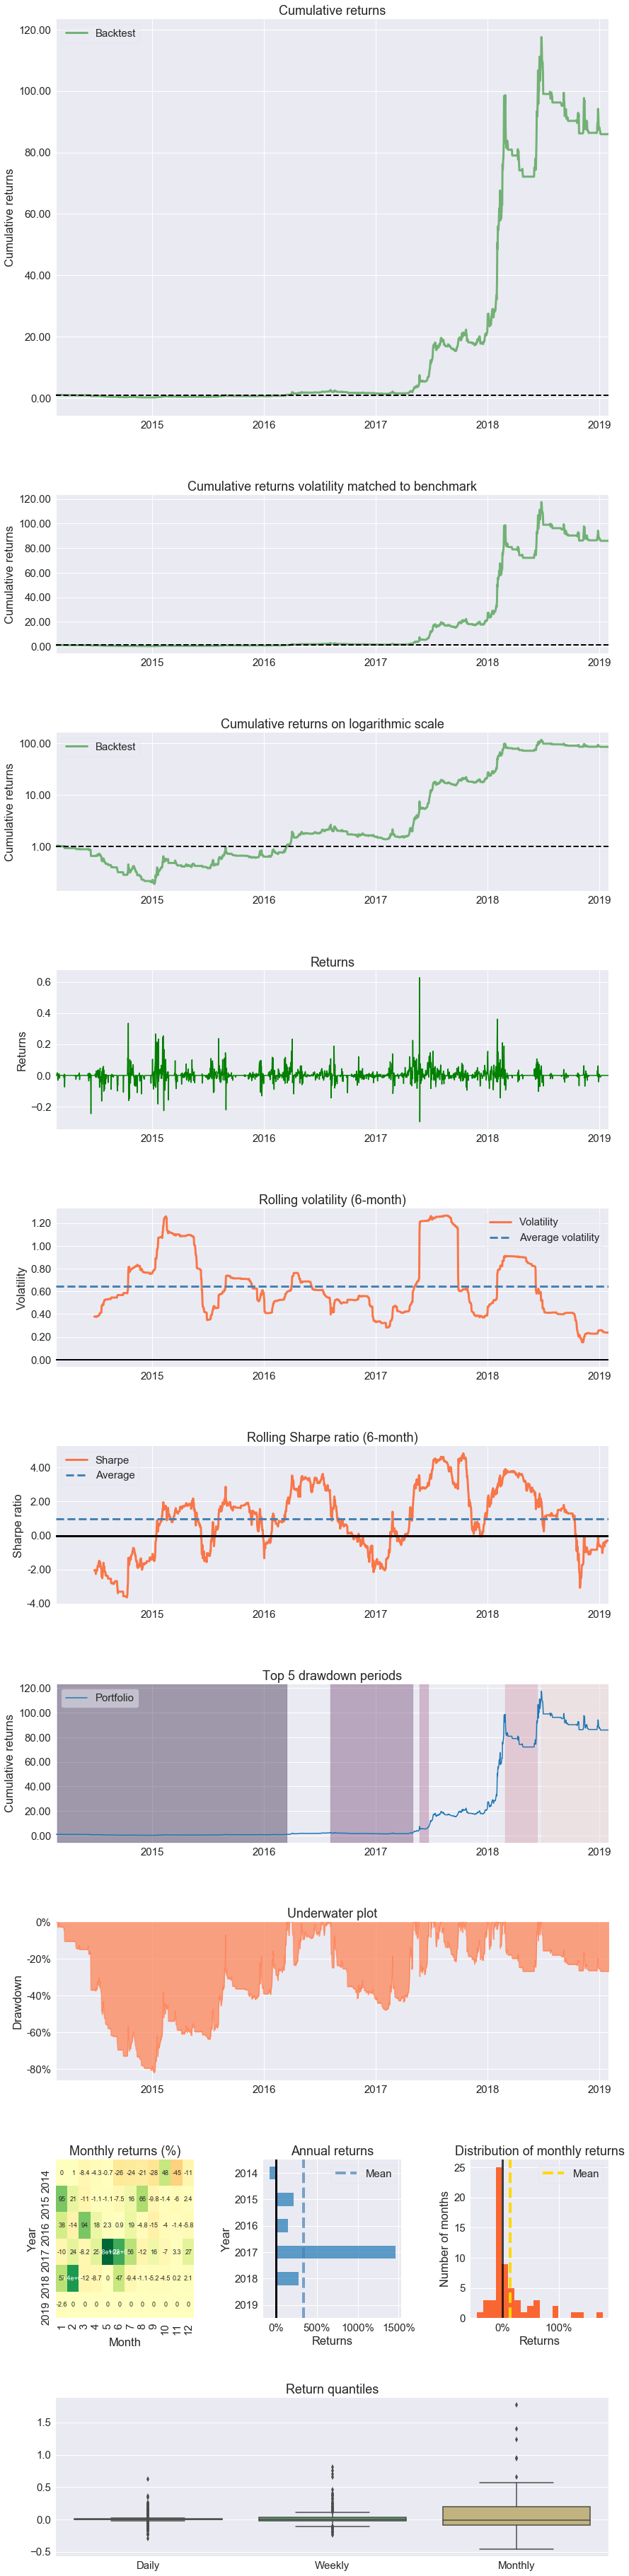

Stress Events,mean,min,max
Apr14,-0.14%,-2.55%,0.00%
Oct14,1.50%,-16.16%,33.49%
Fall2015,0.49%,-22.11%,14.54%
New Normal,0.34%,-29.76%,62.69%


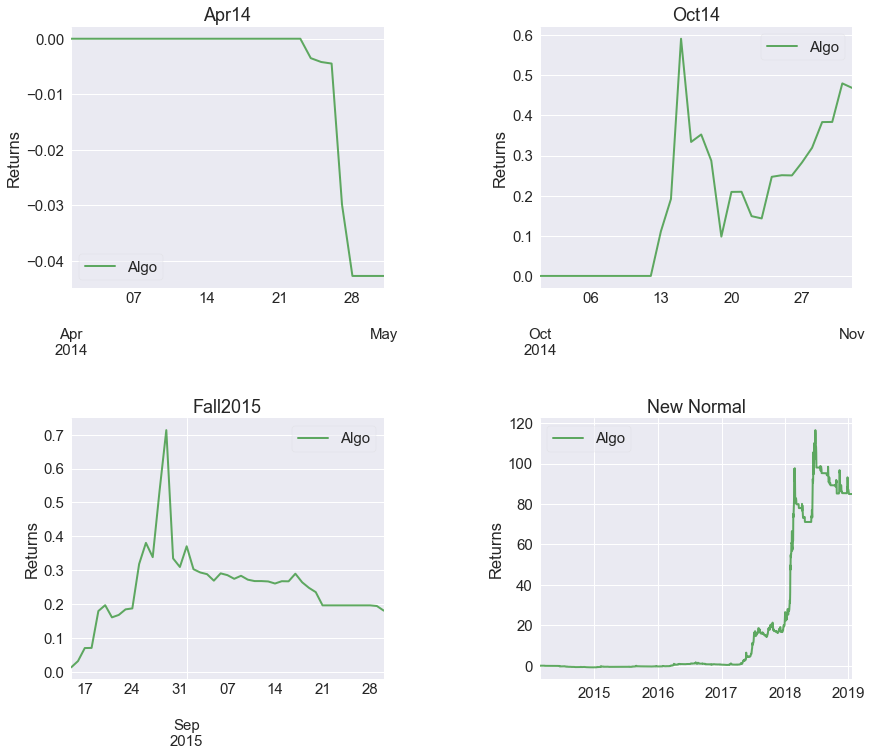

In [193]:
create_full_tear_sheet(returns)



Need positions and transactions data (see below). Other data?
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - Time series with decimal returns.
         - Example:
            2015-07-16    -0.012143
            2015-07-17    0.045350
            2015-07-20    0.030957
            2015-07-21    0.004902
    positions : pd.DataFrame, optional
        Daily net position values.
         - Time series of dollar amount invested in each position and cash.
         - Days where stocks are not held can be represented by 0 or NaN.
         - Non-working capital is labelled 'cash'
         - Example:
            index         'AAPL'         'MSFT'          cash
            2004-01-09    13939.3800     -14012.9930     711.5585
            2004-01-12    14492.6300     -14624.8700     27.1821
            2004-01-13    -13853.2800    13653.6400      -43.6375
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - One row per trade.
        - Trades on different names that occur at the
          same time will have identical indicies.
        - Example:
            index                  amount   price    symbol
            2004-01-09 12:18:01    483      324.12   'AAPL'
            2004-01-09 12:18:01    122      83.10    'MSFT'
            2004-01-13 14:12:23    -75      340.43   'AAPL'
    market_data : pd.Panel, optional
        Panel with items axis of 'price' and 'volume' DataFrames.
        The major and minor axes should match those of the
        the passed positions DataFrame (same dates and symbols).
    slippage : int/float, optional
        Basis points of slippage to apply to returns before generating
        tearsheet stats and plots.
        If a value is provided, slippage parameter sweep
        plots will be generated from the unadjusted returns.
        Transactions and positions must also be passed.
        - See txn.adjust_returns_for_slippage for more details.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period. This datetime should be normalized.
    hide_positions : bool, optional
        If True, will not output any symbol names.
    bayesian: boolean, optional
        If True, causes the generation of a Bayesian tear sheet.
    round_trips: boolean, optional
        If True, causes the generation of a round trip tear sheet.
    sector_mappings : dict or pd.Series, optional
        Security identifier to sector mapping.
        Security ids as keys, sectors as values.
    estimate_intraday: boolean or str, optional
        Instead of using the end-of-day positions, use the point in the day
        where we have the most $ invested. This will adjust positions to
        better approximate and represent how an intraday strategy behaves.
        By default, this is 'infer', and an attempt will be made to detect
        an intraday strategy. Specifying this value will prevent detection.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - The cone is a normal distribution with this standard deviation
             centered around a linear regression.
    bootstrap : boolean (optional)
        Whether to perform bootstrap analysis for the performance
        metrics. Takes a few minutes longer.
    turnover_denom : str
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    factor_returns : pd.Dataframe, optional
        Returns by factor, with date as index and factors as columns
    factor_loadings : pd.Dataframe, optional
        Factor loadings for all days in the date range, with date and
        ticker as index, and factors as columns.
    pos_in_dollars : boolean, optional
        indicates whether positions is in dollars
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    set_context : boolean, optional
        If True, set default plotting style context.
         - See plotting.context().
    factor_partitions : dict, optional
        dict specifying how factors should be separated in perf attrib
        factor returns and risk exposures plots
        - See create_perf_attrib_tear_sheet().